En cuadernos anteriores se encontró con el problema de que algunos sensores se quedaban trabados y mostraban la misma lectura durante horas. Este cuaderno arreglará este problema.

Autor: Duo

In [1279]:
from sklearn.experimental import enable_iterative_imputer

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import IterativeImputer

In [1280]:
df = pd.read_csv("/home/duo/Projects/proyecto-computacion-I/data/datasets/Metricas_limpias.csv")

In [1281]:
df.columns

Index(['timestamp', 'value', 'sensor_id', 'metric', 'unit', 'batch',
       'trans_value', 'z_score_abs'],
      dtype='object')

In [1282]:
df.metric.unique()

array(['PH', 'AMONIO', 'CLOROFILA', 'CARBONO ORGANICO',
       'OXIGENO DISUELTO', 'CONDUCTIVIDAD', 'TURBIDEZ', 'TEMPERATURA',
       'FICOCIANINAS', 'NIVEL', 'FOSFATOS', 'NITRATOS'], dtype=object)

Esta función está explicada en otro cuaderno

In [1383]:
def pintar_graficas(df_input):
    # Evitar modificar el dataframe original fuera de la función
    df = df_input.copy()

    if df.empty:
        print("El DataFrame pasado está vacío.")
        return

    df['timestamp'] = pd.to_datetime(df['timestamp'])

    sns.set_theme(style="whitegrid", palette="muted")
    metrics = df['metric'].unique()

    for metric in metrics:
        subset = df[df['metric'] == metric]

        if len(subset) < 10:
            print(f"Métrica '{metric}' ignorada: muy pocos datos ({len(subset)}).")
            continue

        plt.figure(figsize=(10, 6))

        sns.lineplot(data=subset, x="timestamp", y="value", hue="sensor_id", marker='o')

        plt.title(f"Métrica: {metric}")
        plt.xlabel("Fecha")
        plt.ylabel("Valor")
        plt.xticks(rotation=45)

        if metric == 'TEMPERATURA':
            media = subset['value'].mean()

            plt.ylim(media - 5, media + 5)

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

In [1284]:
df['z_score_abs']

0         4.440892e-09
1         1.774644e+00
2         6.388911e-01
3         1.691932e+00
4         3.181695e+00
              ...     
278032    9.195018e-01
278033    0.000000e+00
278034    6.869899e-01
278035    5.747907e-01
278036    1.025673e+00
Name: z_score_abs, Length: 278037, dtype: float64

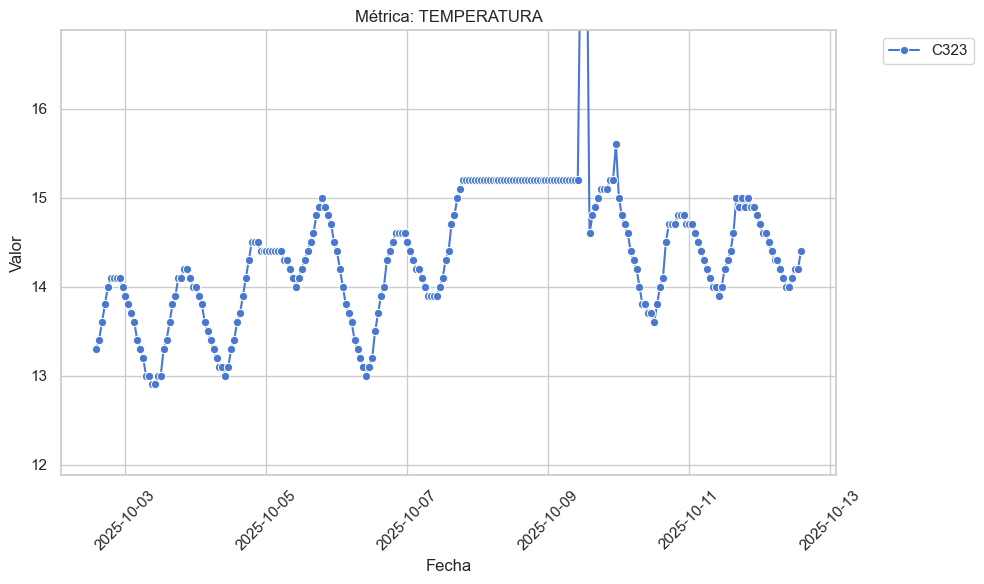

In [1285]:
pintar_graficas(df[(df['batch'] == 'batch1') & (df['sensor_id'] == 'C323') & (df['metric'] == 'TEMPERATURA')])

Este es el problema que se quiere abordar. Solo vamos a abordar las variables de ciclo diario ya que para una demostración académica es más que suficiente.
Estas son las variables que vamos a tratar:

TEMPERATURA: El ciclo día/noche es ineludible. Además, la inercia térmica impide cambios instantáneos, pero también impide la estabilidad absoluta perfecta (siempre hay decimales variando).

OXIGENO DISUELTO (OD): Es la respiración del agua. Sube de día (fotosíntesis) y baja de noche (respiración). Si el OD está plano, la membrana del sensor está sucia o el sensor se ha colgado.

PH: Aunque es más estable, en un río el pH fluctúa con el OD debido al ciclo del CO2/Carbonatos. Un pH clavado en 7.00 o 8.15 durante 6 horas es sospechoso, a menos que sea un agua extremadamente tamponada (poco probable en río abierto).

CLOROFILA / FICOCIANINAS: Son pigmentos de algas. Se mueven con la luz y las corrientes. Valores estáticos aquí suelen indicar que el sensor óptico tiene biofouling (algas pegadas en la lente) y está leyendo su propia suciedad constantemente.

Limpiamos previamente usando el pipeline de hardlimits definida en Serialización parquet.

Esto no hace la inputación, sino que solo los elimina para que más adelante no salten como errores de flatline cuando son errores de engocio

In [1286]:
df

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00
...,...,...,...,...,...,...,...,...
278032,2025-12-19T19:00:00.000000000Z,12.000000,C314,TEMPERATURA,ºC,batch9,12.000000,9.195018e-01
278033,2025-12-19T19:00:00.000000000Z,0.000000,C308,AMONIO,mg/l,batch9,0.000000,0.000000e+00
278034,2025-12-19T19:00:00.000000000Z,8.400000,C329,PH,ph,batch9,8.400000,6.869899e-01
278035,2025-12-19T19:00:00.000000000Z,0.741937,C304,FOSFATOS,ppm,batch9,0.741937,5.747907e-01


In [1287]:
# --- CONFIGURACIÓN DE FÍSICA ESTÁTICA ---
HARD_LIMITS = {
    'AMONIO': (0.0, 20.0),
    'CARBONO ORGANICO': (0.0, 50.0),
    'CLOROFILA': (0.001, 500.0),
    'CONDUCTIVIDAD': (20.0, 5000.0),
    'FICOCIANINAS': (0.0, 1000.0),
    'FOSFATOS': (0.0, 10.0),
    'NITRATOS': (0.0, 250.0),
    'NIVEL': (0.0, 20.0),
    'OXIGENO DISUELTO': (0.001, 20.0),
    'PH': (4.0, 10.5),
    'TEMPERATURA': (0.001, 38.0),
    'TURBIDEZ': (0.0, 2000.0),
}

# --- CONFIGURACIÓN DE FÍSICA DINÁMICA (SALTOS MÁXIMOS/HORA) ---
# Cuánto es lo máximo que puede variar X en 1 hora antes de considerarlo error
JUMP_LIMITS = {
    'TEMPERATURA': 4.0,  # 4ºC es un margen muy seguro
    'PH': 2.0,  # 2.0 unidades es un cambio químico brutal
    'OXIGENO DISUELTO': 5.0,  # 5 ppm/h. Un cambio mayor implica fallo de membrana del sensor.
    'CLOROFILA': 20  # si 25ppb es Hiper-eutrófico (Bloom/Sopa)	>25	Sopa de guisantes / Natas
}


def clean_physics_and_coherence(df):
    """
    Aplica Hard Limits (Rango) y Coherencia Temporal (Saltos) de forma modular.
    """
    df_clean = df.copy()
    initial_nans = df_clean['value'].isna().sum()

    print("--- INICIO SANEAMIENTO FÍSICO ---")

    # 1. HARD LIMITS (Rango Absoluto)
    print("   > Aplicando Límites Estáticos...")
    for metric, (min_val, max_val) in HARD_LIMITS.items():
        mask = (df_clean['metric'] == metric) & \
               ((df_clean['value'] < min_val) | (df_clean['value'] > max_val))

        count = mask.sum()
        if count > 0:
            print(f"     [{metric}] Eliminados {count} valores fuera de rango ({min_val}-{max_val})")
            df_clean.loc[mask, 'value'] = np.nan

    # 2. COHERENCIA TEMPORAL (Saltos Bruscos)
    print("   > Aplicando Coherencia Dinámica (Max Jumps)...")

    # Ordenamos OBLIGATORIAMENTE para calcular diferencias temporales
    df_clean.sort_values(by=['sensor_id', 'metric', 'timestamp'], inplace=True)

    # Iteramos solo por las métricas que tienen definida una restricción de salto
    for metric, max_jump in JUMP_LIMITS.items():
        # Máscara de la métrica
        mask_metric = df_clean['metric'] == metric

        if mask_metric.sum() == 0:
            continue

        # Calculamos la diferencia absoluta con el valor anterior (agrupado por sensor)
        # Esto evita comparar el último dato del sensor A con el primero del sensor B
        # Transform devuelve un vector alineado con el original
        deltas = df_clean[mask_metric].groupby('sensor_id')['value'].diff().abs()

        # Identificamos violaciones
        # Es importante notar que si el anterior es NaN, el diff será NaN (seguro)
        violation_mask = deltas > max_jump

        # Ahora necesitamos mapear esta violación (que es un subset) al dataframe original
        # Como usamos transform o índices alineados, podemos hacerlo directo.
        # Pero diff() se hizo sobre un subset filtrado.

        # Forma segura: Usamos los índices del subset
        indices_to_kill = df_clean[mask_metric][violation_mask].index

        count = len(indices_to_kill)
        if count > 0:
            print(f"     [{metric}] Eliminados {count} saltos imposibles (> {max_jump} ud/h)")
            df_clean.loc[indices_to_kill, 'value'] = np.nan

    # Estadísticas finales
    final_nans = df_clean['value'].isna().sum()
    print(f"--- FIN LIMPIEZA ---")
    print(f"Total purgado en esta fase: {final_nans - initial_nans}")

    return df_clean

In [1288]:
df = clean_physics_and_coherence(df)

--- INICIO SANEAMIENTO FÍSICO ---
   > Aplicando Límites Estáticos...
     [CLOROFILA] Eliminados 1565 valores fuera de rango (0.001-500.0)
     [CONDUCTIVIDAD] Eliminados 37157 valores fuera de rango (20.0-5000.0)
     [FICOCIANINAS] Eliminados 28 valores fuera de rango (0.0-1000.0)
     [OXIGENO DISUELTO] Eliminados 2852 valores fuera de rango (0.001-20.0)
     [PH] Eliminados 4261 valores fuera de rango (4.0-10.5)
     [TEMPERATURA] Eliminados 2891 valores fuera de rango (0.001-38.0)
   > Aplicando Coherencia Dinámica (Max Jumps)...
     [TEMPERATURA] Eliminados 18 saltos imposibles (> 4.0 ud/h)
     [PH] Eliminados 7 saltos imposibles (> 2.0 ud/h)
     [OXIGENO DISUELTO] Eliminados 22 saltos imposibles (> 5.0 ud/h)
--- FIN LIMPIEZA ---
Total purgado en esta fase: 48801


In [1289]:
# Distribuciones Normales vs Log-Normales (Cola pesada)
METRICS_NORMAL = ['PH', 'TEMPERATURA', 'OXIGENO DISUELTO', 'NIVEL']
METRICS_LOG = ['AMONIO', 'TURBIDEZ', 'NITRATOS', 'FOSFATOS',
               'CLOROFILA', 'FICOCIANINAS', 'CONDUCTIVIDAD', 'CARBONO ORGANICO']

ZSCORE_PARAMS = {
    'window': 96,  # 4 días (96 horas) para absorber lluvias
    'min_periods': 24,  # Mínimo 1 día de historia para opinar
    'sigma': 6.0,  # Umbral de corte (Sigma 6 es muy generoso con eventos reales)
    'epsilon': 1e-6  # Evitar división por cero
}

In [1290]:
def apply_zscore_outliers(df):
    """
    Filtro Estadístico Avanzado (Rolling Z-Score).
    - Aplica log1p a métricas de cola pesada (Log-Normales).
    - Calcula media y std en ventana móvil de 4 días.
    - Elimina lo que supere 6 sigmas.
    - RESPETA BATCHES: No mezcla estadísticas de periodos desconectados.
    """
    df_proc = df.copy()
    nans_start = df_proc['value'].isna().sum()

    print(f"--- APLICANDO Z-SCORE (Sigma {ZSCORE_PARAMS['sigma']}) POR BATCH ---")

    # 1. Preparación y Transformación Logarítmica
    df_proc['calc_value'] = df_proc['value']

    mask_log = df_proc['metric'].isin(METRICS_LOG)
    df_proc.loc[mask_log, 'calc_value'] = np.log1p(df_proc.loc[mask_log, 'value'])

    # 2. Ordenación Crítica (Incluyendo Batch)
    # Vital: Ordenamos por Batch y luego Tiempo para que el rolling fluya correctamente
    df_proc.sort_values(by=['sensor_id', 'metric', 'batch', 'timestamp'], inplace=True)

    # 3. Agrupación Estanca (Incluyendo Batch)
    # Al añadir 'batch' al groupby, la ventana móvil se rompe y reinicia
    # cada vez que cambia el número de lote.
    grouper = df_proc.groupby(['sensor_id', 'metric', 'batch'])['calc_value']

    # Calculamos media y std móviles
    roll_mean = grouper.transform(lambda x: x.rolling(
        window=ZSCORE_PARAMS['window'],
        min_periods=ZSCORE_PARAMS['min_periods'],
        center=True
    ).mean())

    roll_std = grouper.transform(lambda x: x.rolling(
        window=ZSCORE_PARAMS['window'],
        min_periods=ZSCORE_PARAMS['min_periods'],
        center=True
    ).std())

    # 4. Cálculo del Z-Score
    denominator = np.where(roll_std > ZSCORE_PARAMS['epsilon'], roll_std, ZSCORE_PARAMS['epsilon'])
    z_scores = (df_proc['calc_value'] - roll_mean) / denominator

    # Rellenamos NaNs (inicios de batch sin suficiente historia) con 0
    z_scores = z_scores.fillna(0)

    # 5. La Purga
    mask_outlier = z_scores.abs() > ZSCORE_PARAMS['sigma']
    count = mask_outlier.sum()

    if count > 0:
        breakdown = df_proc[mask_outlier]['metric'].value_counts()
        print(f"   Detectados {count} outliers estadísticos.")
        print(f"   Top culpables: \n{breakdown.head(3)}")

        df_proc.loc[mask_outlier, 'value'] = np.nan

    # Limpieza
    df_proc.drop(columns=['calc_value'], inplace=True)

    print(f"   -> Total purgado: {df_proc['value'].isna().sum() - nans_start}")
    return df_proc

Purgar errores de lecturas/anomalías extremas, recordamos que usamos de threshold 6 sigma

In [1291]:
df = apply_zscore_outliers(df)

--- APLICANDO Z-SCORE (Sigma 6.0) POR BATCH ---
   Detectados 94 outliers estadísticos.
   Top culpables: 
metric
TURBIDEZ            23
FOSFATOS            13
CARBONO ORGANICO    12
Name: count, dtype: int64
   -> Total purgado: 94


Separaremos en tres niveles de detección:
### Nivel 1
Es el fallo más tonto, pero ocurre. El sensor envía exactamente el mismo float una y otra vez.

1. Lógica: Contamos cuántos valores consecutivos son idénticos.
2. Criterio: Si Valort​==Valort−1​==...==Valort−n​ durante, por ejemplo, 60 minutos.
3. Por qué es avanzado: Porque en variables flotantes (con muchos decimales), la probabilidad de que la temperatura sea exactamente 14.23456 durante una hora es estadísticamente nula. Si ocurre, es un error de software/transmisión.

### Nivel 2
Aquí el sensor no da el mismo número exacto (quizás oscila entre 7.01 y 7.02), pero la señal ha perdido su vida.

1. Lógica: Calculamos la Desviación Estándar (σ) en una ventana rodante.

2. Criterio: Si σ<ϵ (donde ϵ es la resolución del sensor o un margen de ruido mínimo) durante X horas.

3. Caso Práctico: Clorofila: Es ruidosa por naturaleza. Si la desviación estándar cae casi a cero, significa que el sensor óptico probablemente está tapado (biofouling) y está leyendo un valor constante de "oscuridad" o "verde fijo", ignorando el agua que pasa.

### Nivel 3
Aprovechamos que estas 5 variables son de ciclo diario.
1. Lógica: Derivada temporal
2. Razonamiento: Sabemos que la temperatura y el OD tienen que cambiar cuando sale o se pone el sol.
3. Criterio: Si estamos en la ventana de tiempo del "amanecer" o "atardecer" (donde la derivada debería ser máxima) y la tasa de cambio es cercana a 0, marcamos un flatline.

Ejemplo: Si son las 09:00 AM (sol subiendo) y la Temperatura no ha subido más de 0.1∘C en 2 horas, el sensor está aislado térmicamente (quizás enterrado en lodo o fuera del agua).

# Planteamientos iniciales

## Cálculo de granularidad empírica
Calcula las diferencias absolutas entre todas las lecturas consecutivas de la historia, elimina los ceros, y busca el valor mínimo.
Si el sensor reporta 14.5, 14.5, 14.6, la diferencia mínima es 0.1. Esa es la resolución real.

## Rolling MAD
La desviación estándar (y el Z-Score) son sensibles a outliers (esto lo habíamos utilizado en los cuadernos de detección de anomalías). Aquí usaremos la MAD (Median Absolute Deviation) en una ventana rodante (ej. 6 o 12 horas).

## Convexidad
Los ciclos día/noche (Temperatura, pH, OD) son ondas senoidales. Tienen curvatura constante.
Una línea recta (flatline o deriva) no tiene curvatura.

Si ∑window​∣Δ2x∣≈0 durante 6 horas en una variable cíclica (como Temperatura), el sensor es artificial. La naturaleza siempre dobla la curva hacia arriba (mañana) o hacia abajo (tarde).

## Entropía de permutación

La entropía mide el desorden. Una señal natural, aunque sea estable, tiene "micro-desorden" en el orden de sus decimales. Tomamos una ventana de 5 o 6 puntos horarios. Miramos el orden relativo (ej: x1​<x2​>x3​).

1. Señal real: Patrones de orden complejos.

2. Flatline o Loop de error: Patrones repetitivos o nulos.

Todos estos planteamientos tienen el problema de que dependen de un contexto de ventana fija. Los siguientes algoritmos no tienen ese problema. Y son los que realmente vamos a utilizar.

# Algoritmos
## MVP - primera pasada
 No podemos permitir que el sensor aprenda datos basura, así que vamos a verificar algunas cosas preflight

## Mapa de volatilidad esperada
Antes de procesar nada, necesitamos que el sistema aprenda qué es lo normal para cada hora del día para cada métrica.

Calcularemos el Perfil de Volatilidad Horaria (σexpected​). Para cada hora del día (h∈[0,23]), calculamos la desviación típica histórica (o el rango intercuartílico, que es más robusto) de esa variable.

- σ14:00​ (Mediodía) → Será Alta (ej. 0.5 variabilidad).

- σ04:00​ (Madrugada) → Será Baja (ej. 0.05 variabilidad).

Esto nos da una curva de latido del río.

## El Score de Estancamiento Acumulativo
En lugar de mirar hacia atrás 6 horas fijas, vamos a tener un contador (un score) que avanza con el tiempo. Lo llamaremos Sstagnant​.

Para cada nueva lectura en el tiempo t:

1. Evaluación Instantánea: Calculamos la quietud actual usando la lógica de MAD o 2ª Derivada que hablamos antes.

¿Está el dato quieto respecto al anterior? Sí/No.

Ponderación por Contexto: Si está quieto, sumamos puntos al Score, pero ponderados por la volatilidad esperada.
   Penaltyt​=δmin​σexpected​(ht​)​

- Si el sensor se queda quieto a las 14:00 (cuando σexpected​ es alta), el Penalty es gigante. El Score sube rapidísimo. Quizás en 2 horas ya superas el umbral de alarma.

- Si el sensor se queda quieto a las 04:00 (cuando σexpected​ es baja), el Penalty es pequeño. El Score sube lento. Necesitas muchas horas de quietud para disparar la alarma.

- Reset Dinámico: En el momento en que el sensor muestra una variación "sana" (superior al ruido de fondo), el Score se resetea a 0. El sensor está vivo.


## Region Growing (Cultivo de Regiones)

En vez de cortar por ventanas, usamos el Score para definir Eventos.

Cuando Sstagnant​>Threshold, se abre un Incidente de Flatline.

- El incidente sigue abierto hasta que el Score cae a 0.

- Esto nos dará automáticamente una tupla: (start_time, end_time).

- Para Temperatura en día: El sistema detectará un flatline corto (ej. 13:00 a 15:00).

- Para pH en noche: El sistema exigirá un flatline largo (ej. 01:00 a 08:00) para marcarlo.

## La Validación Cruzada de Sensores (Spatial Sanity Check)

Si el algoritmo de arriba marca un posible flatline en el sensor A (Score alto), antes de condenar el dato, el algoritmo "mira" a los sensores vecinos (B y C) o a otras métricas del mismo sensor (ej. Turbidez).

- Regla de Elasticidad: Si los vecinos B y C también tienen una volatilidad inusualmente baja en ese momento (quizás es un día excepcionalmente calmo sin viento), aumentamos el umbral de tolerancia del sensor A dinámicamente.

- Regla de Condena: Si los vecinos B y C se están moviendo como locos y A está quieto (Score alto), confirmamos el flatline inmediatamente.

### Segmentación

Comanzamos con la segmentación. Existen saltos entre batches que vamos a tener en cuenta

In [1292]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['sensor_id', 'batch', 'timestamp'])

Detección de Rupturas (Vectorizado y Rápido). Calculamos la diferencia de tiempo con la fila anterior (en todo el DF a la vez)

Usamos 'shift()' para comparar con la fila previa

In [1293]:
time_diff = df['timestamp'].diff()

La condición de ruptura es que cambió el batch

In [1294]:
cond_batch = df['batch'] != df['batch'].shift()

Silencio Global > 1.1 horas
Si hay 10 sensores reportando a las 10:00, la diferencia entre ellos será 0 o ms.
El salto solo ocurrirá cuando pasemos del último dato de las 10:00 al primero de las 11:00.
Si ese salto es > 1.1h, significa que TODO el sistema se cayó o hubo un hueco.

In [1295]:
cond_gap = time_diff > pd.Timedelta(hours=1.1)

Creamos el ID (Suma acumulativa de rupturas)

In [1296]:
df['segment_id'] = (cond_batch | cond_gap).cumsum()

In [1297]:
df.head()

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs,segment_id
215,2025-10-02 15:00:00+00:00,0.392042,C302,AMONIO,mg/l,batch1,0.392042,0.359056,1
188,2025-10-02 15:00:00+00:00,NaN,C302,CONDUCTIVIDAD,micrS/cm,batch1,7.455298,1.461383,1
136,2025-10-02 15:00:00+00:00,0.000000,C302,NITRATOS,ppm,batch1,0.000000,0.000000,1
87,2025-10-02 15:00:00+00:00,8.820000,C302,OXIGENO DISUELTO,ppm,batch1,8.820000,1.806873,1
142,2025-10-02 15:00:00+00:00,8.100000,C302,PH,ph,batch1,8.100000,1.170826,1


### Cálculo de deltas


Ahora, aunque comparten segmento, para calcular la volatilidad (delta),
cada sensor solo se compara consigo mismo.

Agrupamos por:
- segment_id: Para no saltar huecos temporales grandes/cambios de batch
- sensor_id: Para comparar peras con peras
- metric: Para comparar pH con pH

In [1298]:
g = df.groupby(['segment_id', 'sensor_id', 'metric'])

Calculamos el cambio de valor Y el cambio de tiempo real entre lecturas propias

In [1299]:
df['prev_value'] = g['value'].shift(1)
df['prev_timestamp'] = g['timestamp'].shift(1)

df['delta_abs'] = (df['value'] - df['prev_value']).abs()
df['own_time_diff'] = df['timestamp'] - df['prev_timestamp']

Aquí resolvemos el caso borde: ¿Qué pasa si el Sensor A falló a las 11:00 pero el B no?
El segmento global sigue vivo (gracias a B), pero A tiene un salto de 10:00 a 12:00.
No queremos calcular volatilidad con un salto de 2 horas.

Solo validamos deltas donde el salto de tiempo PROPIO del sensor sea ~1 hora

In [1300]:
valid_delta_mask = df['own_time_diff'] <= pd.Timedelta(hours=1.1)

Dataset limpio para calcular la Matriz de Expectativa

In [1301]:
df_clean_deltas = df[valid_delta_mask & df['delta_abs'].notna()].copy()

print(f"Segmentos detectados: {df['segment_id'].nunique()}")
df_clean_deltas.head()

Segmentos detectados: 240


,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs,segment_id,prev_value,prev_timestamp,delta_abs,own_time_diff
432,2025-10-02 16:00:00+00:00,0.392042,C302,AMONIO,mg/l,batch1,0.392042,0.290436,1,0.392042,2025-10-02 15:00:00+00:00,0.00,0 days 01:00:00
353,2025-10-02 16:00:00+00:00,0.000000,C302,NITRATOS,ppm,batch1,0.000000,0.000000,1,0.000000,2025-10-02 15:00:00+00:00,0.00,0 days 01:00:00
304,2025-10-02 16:00:00+00:00,8.840000,C302,OXIGENO DISUELTO,ppm,batch1,8.840000,1.766053,1,8.820000,2025-10-02 15:00:00+00:00,0.02,0 days 01:00:00
359,2025-10-02 16:00:00+00:00,8.100000,C302,PH,ph,batch1,8.100000,1.142857,1,8.100000,2025-10-02 15:00:00+00:00,0.00,0 days 01:00:00
462,2025-10-02 16:00:00+00:00,18.300000,C302,TEMPERATURA,ºC,batch1,18.300000,0.869670,1,18.200000,2025-10-02 15:00:00+00:00,0.10,0 days 01:00:00


### Descubrimiento de resolución

Buscamos la diferencia mínima NO-CERO para cada sensor/métrica. Esto nos dice el paso mínimo que el hardware puede dar.

In [1302]:
non_zero_deltas = df_clean_deltas[df_clean_deltas['delta_abs'] > 0]

# Agrupamos por sensor y métrica
epsilon_map = non_zero_deltas.groupby(['sensor_id', 'metric'])['delta_abs'].min().reset_index()
epsilon_map.rename(columns={'delta_abs': 'epsilon'}, inplace=True)

# Safety: Si por alguna razón matemática extraña da 0 (float precision), forzamos un mínimo
epsilon_map['epsilon'] = epsilon_map['epsilon'].replace(0, 1e-6)

print("--- Ejemplos de Resolución Detectada ---")
epsilon_map

--- Ejemplos de Resolución Detectada ---


,sensor_id,metric,epsilon
0,C302,AMONIO,0.006734
1,C302,OXIGENO DISUELTO,0.010000
2,C302,PH,0.100000
3,C302,TEMPERATURA,0.100000
4,C302,TURBIDEZ,0.002395
...,...,...,...
155,C344,FICOCIANINAS,0.042560
156,C344,OXIGENO DISUELTO,0.010000
157,C344,PH,0.100000
158,C344,TEMPERATURA,0.100000


Bien, vemos que no hay ningún epsion de 1e-6

### Perfilado de Volatilidad

Ahora calculamos cuánto suele variar esa métrica a esa hora. Al utilizar la mediana, no nos importa tanto los flat lines ya que siempre que los datos reales tengan una prevalencia superior al 50% podremos detectar un baseline efectivo

In [1303]:
df_clean_deltas['hour'] = df_clean_deltas['timestamp'].dt.hour

Agrupamos por Sensor, Métrica y Hora
Usamos MEDIANA para que sea robusto a flatlines pasados.

In [1304]:
volatility_profile = df_clean_deltas.groupby(['sensor_id', 'metric', 'hour'])['delta_abs'].median().reset_index()
volatility_profile.rename(columns={'delta_abs': 'expected_vol'}, inplace=True)

Vamos a cerciorarnos de que no haya nulos

Calculamos Defaults Globales por Métrica
Si no sé la resolución de este sensor de pH, uso la típica de los otros sensores de pH

In [1305]:
global_epsilon = epsilon_map.groupby('metric')['epsilon'].median().reset_index()
global_epsilon.rename(columns={'epsilon': 'global_eps'}, inplace=True)

global_vol = volatility_profile.groupby(['metric', 'hour'])['expected_vol'].median().reset_index()
global_vol.rename(columns={'expected_vol': 'global_vol'}, inplace=True)

Relleno Inteligente de Epsilon .Unimos con los defaults globales

Unimos la volatilidad observada con el mapa de epsilon.
"how='left'" mantiene todos los sensores/horas, incluso si no tenemos epsilon para ellos.

In [1306]:
profile_df = pd.merge(volatility_profile, epsilon_map[['sensor_id', 'metric', 'epsilon']],
                      on=['sensor_id', 'metric'], how='left')

Relleno Inteligente de Perfil de Volatilidad Unimos con defaults globales

In [1307]:
profile_df = pd.merge(profile_df, global_epsilon, on='metric', how='left')
profile_df = pd.merge(profile_df, global_vol, on=['metric', 'hour'], how='left')

Relleno de Epsilon (Cascada de prioridad)
Prioridad: Epsilon Propio -> Epsilon Global de la Métrica -> 0.01 (Default duro)

In [1308]:
profile_df['epsilon'] = profile_df['epsilon'].fillna(profile_df['global_eps']).fillna(0.01)

Prioridad: Volatilidad Propia -> Volatilidad Global -> Epsilon (asumir quietud mínima)

In [1309]:
profile_df['expected_vol'] = profile_df['expected_vol'].fillna(profile_df['global_vol']).fillna(profile_df['epsilon'])

REGLA DE ORO: La volatilidad esperada NUNCA puede ser menor que la resolución del sensor.
Si la mediana dio 0 (porque el río es muy calmado), la subimos a epsilon.

In [1310]:
profile_df['expected_vol'] = profile_df[['expected_vol', 'epsilon']].max(axis=1)

Calculamos la "Severidad Base" por hora
Severity = Cuántas veces el epsilon debería haberse movido el sensor.
Si a las 14:00 lo normal es variar 0.10 y mi epsilon es 0.01 -> Severity = 10 puntos/hora

In [1311]:
profile_df['severity_rate'] = profile_df['expected_vol'] / profile_df['epsilon']

print("\n--- Perfil de Volatilidad Generado (Top 5) ---")
profile_df


--- Perfil de Volatilidad Generado (Top 5) ---


,sensor_id,metric,hour,expected_vol,epsilon,global_eps,global_vol,severity_rate
0,C302,AMONIO,0,0.006734,0.006734,0.005938,0.007731,1.0
1,C302,AMONIO,1,0.006734,0.006734,0.005938,0.000000,1.0
2,C302,AMONIO,2,0.006734,0.006734,0.005938,0.007843,1.0
3,C302,AMONIO,3,0.006734,0.006734,0.005938,0.000000,1.0
4,C302,AMONIO,4,0.006734,0.006734,0.005938,0.000000,1.0
...,...,...,...,...,...,...,...,...
4315,C345,TURBIDEZ,19,0.005900,0.005900,0.005900,0.019431,1.0
4316,C345,TURBIDEZ,20,0.005900,0.005900,0.005900,0.021849,1.0
4317,C345,TURBIDEZ,21,0.005900,0.005900,0.005900,0.022195,1.0
4318,C345,TURBIDEZ,22,0.005900,0.005900,0.005900,0.016039,1.0


Verificar nulos

In [1312]:
nulos_restantes = profile_df[['epsilon', 'severity_rate']].isna().sum()
print("Nulos restantes (deben ser 0):")
print(nulos_restantes)

print("\n--- Ejemplo de Perfil Corregido ---")
profile_df.head()

Nulos restantes (deben ser 0):
epsilon          0
severity_rate    0
dtype: int64

--- Ejemplo de Perfil Corregido ---


,sensor_id,metric,hour,expected_vol,epsilon,global_eps,global_vol,severity_rate
0,C302,AMONIO,0,0.006734,0.006734,0.005938,0.007731,1.0
1,C302,AMONIO,1,0.006734,0.006734,0.005938,0.000000,1.0
2,C302,AMONIO,2,0.006734,0.006734,0.005938,0.007843,1.0
3,C302,AMONIO,3,0.006734,0.006734,0.005938,0.000000,1.0
4,C302,AMONIO,4,0.006734,0.006734,0.005938,0.000000,1.0


## Cálculo del Score de Estancamiento

unimos todo

In [1313]:
df['hour'] = df['timestamp'].dt.hour
df_scored = pd.merge(df, profile_df[['sensor_id', 'metric', 'hour', 'epsilon', 'severity_rate']],
                     on=['sensor_id', 'metric', 'hour'], how='left')
df_scored = df_scored.sort_values(by=['sensor_id', 'metric', 'timestamp'])

Usamos la columna 'delta_abs' que calculamos respetando los segmentos.
Condición: El cambio es menor que la resolución DEL SENSOR (epsilon) Y no es un inicio de segmento (NaN)

In [1314]:
df_scored['is_quiet'] = (df_scored['delta_abs'] < df_scored['epsilon']) & (df_scored['delta_abs'].notna())

Queremos sumar severity_rate consecutivamente.

A. Identificamos bloques consecutivos
Cada vez que 'is_quiet' cambia (de True a False o viceversa) o cambiamos de Segmento/Sensor,
generamos un nuevo ID de bloque.
(Añadimos sensor_id y segment_id al cambio para evitar acumular scores entre sensores distintos)

B. Suma Acumulativa (Cumsum) por Bloque
Inicializamos el score a 0

C. Cambiamos de Métrica CRÍTICO No mezclar Temp con pH)
D. Cambiamos de Segmento de datos (huecos temporales grandes)

In [1315]:
df_scored['block_change'] = (df_scored['is_quiet'] != df_scored['is_quiet'].shift()) | \
                            (df_scored['sensor_id'] != df_scored['sensor_id'].shift()) | \
                            (df_scored['metric'] != df_scored['metric'].shift()) | \
                            (df_scored['segment_id'] != df_scored['segment_id'].shift())

# Generamos un ID único para cada racha consecutiva
df_scored['block_id'] = df_scored['block_change'].cumsum()

Filtramos solo las filas donde está quieto (para no perder tiempo calculando ceros)

In [1316]:
quiet_mask = df_scored['is_quiet']

# Agrupamos por bloque y hacemos la suma acumulativa de la severidad
df_scored.loc[quiet_mask, 'stagnation_score'] = (
    df_scored[quiet_mask]
    .groupby('block_id')['severity_rate']
    .cumsum()
)

Vamos a ver los momentos con mayor puntuación de estancamiento.
Estos deberían ser los flatlines más obvios.

In [1317]:
top_flatlines = df_scored.sort_values(by='stagnation_score', ascending=False).head(15)

print("--- Top 15 Momentos de Mayor Estancamiento Detectados ---")
print(top_flatlines[['timestamp', 'sensor_id', 'metric', 'value', 'epsilon', 'severity_rate', 'stagnation_score']])

--- Top 15 Momentos de Mayor Estancamiento Detectados ---
                      timestamp sensor_id  metric    value   epsilon  \
38824 2025-12-09 19:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38815 2025-12-09 18:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38806 2025-12-09 17:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38797 2025-12-09 16:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38788 2025-12-09 15:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38779 2025-12-09 14:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38770 2025-12-09 13:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38761 2025-12-09 12:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38752 2025-12-09 11:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38743 2025-12-09 10:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38734 2025-12-09 09:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38725 2025-12-09 08:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38716 

## Validación de la estrategia

In [1318]:
df_clean = df_scored.copy()

Todo lo que tenga Score > 20 es un sensor muerto -> Lo convertimos a NaN.

El umbral de 20 significa: Exijo que el sensor haya estado quieto un tiempo equivalente a 20 veces su resolución mínima ponderada por la actividad esperada.
Esto implica más o menos 5-6 horas de inactividad
Aplicaremos Fallo Retroactivo

In [1319]:
THRESHOLD_SCORE = 20.0

# Propagamos el veredicto:
# Calculamos el Score MÁXIMO que alcanzó cada bloque y se lo pegamos a todas sus filas.
df_scored['max_score_in_block'] = df_scored.groupby('block_id')['stagnation_score'].transform('max')

Definimos la máscara condenatoria
La condición es: Pertenezco a un bloque que en algún momento cruzó la línea roja.

In [1320]:
mask_toxic_block = df_scored['max_score_in_block'] > THRESHOLD_SCORE

Estadísticas

In [1321]:
puntos_criterio_simple = (df_scored['stagnation_score'] > THRESHOLD_SCORE).sum()
puntos_criterio_retroactivo = mask_toxic_block.sum()

print(f"--- IMPACTO DE LA PURGA RETROACTIVA ---")
print(f"Puntos eliminados (Criterio simple): {puntos_criterio_simple}")
print(f"Puntos eliminados (Criterio correcto): {puntos_criterio_retroactivo}")
print(f"Diferencia (Basura que antes te comías): {puntos_criterio_retroactivo - puntos_criterio_simple}")

--- IMPACTO DE LA PURGA RETROACTIVA ---
Puntos eliminados (Criterio simple): 40914
Puntos eliminados (Criterio correcto): 53174
Diferencia (Basura que antes te comías): 12260


Aplicamos la Purga Real

In [1322]:
df_clean = df_scored.copy()
df_clean.loc[mask_toxic_block, 'value'] = np.nan

Verificamos

In [1323]:
print(f"\nHuecos totales listos para imputar: {df_clean['value'].isna().sum()}")


Huecos totales listos para imputar: 102069


Encontrar los nodos cercanos a mi. Esto se puede realizar gracias a mi trabajo con el censo

Se escriben ya en clases listas para ser utilizadas en el pipeline si todo funciona

In [1324]:
URI = "bolt://192.168.2.7:7687"
AUTH = ("neo4j", "12345678secret")


class GraphNeighborProvider:
    def __init__(self, uri, auth):
        self.driver = GraphDatabase.driver(uri, auth=auth)

    def get_topology(self):
        query = """
        MATCH (target:Sensor)
        WHERE target.id IS NOT NULL

        // 1. HIDROLÓGICO: Aguas Arriba
        OPTIONAL MATCH (up:Sensor)-[r:FLUYE_HACIA*1..3]->(target)
        WITH target, collect({
            neighbor: up.id,
            type: 'UPSTREAM',
            dist: reduce(d=0.0, x in r | d + x.distancia),
            weight: 1.0
        }) as up_neighbors

        // 2. HIDROLÓGICO: Aguas Abajo
        OPTIONAL MATCH (target)-[r:FLUYE_HACIA*1..3]->(down:Sensor)
        WITH target, up_neighbors, collect({
            neighbor: down.id,
            type: 'DOWNSTREAM',
            dist: reduce(d=0.0, x in r | d + x.distancia),
            weight: 0.8
        }) as down_neighbors

        // 3. GEOMÉTRICO: Fallback
        CALL (target) {
            MATCH (geo:Sensor)
            WHERE geo <> target AND geo.utm_x IS NOT NULL AND target.utm_x IS NOT NULL
            WITH target, geo,
                 sqrt((target.utm_x - geo.utm_x)^2 + (target.utm_y - geo.utm_y)^2) as dist_geo
            ORDER BY dist_geo ASC
            LIMIT 3
            RETURN collect({
                neighbor: geo.id,
                type: 'SPATIAL',
                dist: dist_geo,
                weight: 0.2
            }) as spatial_neighbors
        }

        // Fusión
        WITH target.id as target_sensor,
             up_neighbors + down_neighbors + spatial_neighbors as all_candidates

        UNWIND all_candidates as c

        WITH target_sensor, c
        WHERE c.neighbor IS NOT NULL

        RETURN target_sensor,
               c.neighbor as neighbor_sensor,
               c.type as relation_type,
               c.dist as distance_m,
               c.weight as initial_weight
        ORDER BY target_sensor, c.weight DESC, c.dist ASC
        """

        print("Consultando Neo4j para obtener topología hídrica...")
        with self.driver.session() as session:
            result = session.run(query)
            data = [record.data() for record in result]

        return pd.DataFrame(data)

    def close(self):
        self.driver.close()


# --- EJECUCIÓN DE PRUEBA ---
provider = GraphNeighborProvider(URI, AUTH)
try:
    df_topology = provider.get_topology()
    print(f"Topología cargada: {len(df_topology)} relaciones encontradas.")
    print(df_topology.head())
finally:
    provider.close()

Consultando Neo4j para obtener topología hídrica...
Topología cargada: 254 relaciones encontradas.
  target_sensor neighbor_sensor relation_type  distance_m  initial_weight
0          C302            C312      UPSTREAM    16292.36             1.0
1          C302            C320      UPSTREAM    70000.12             1.0
2          C302            C316      UPSTREAM   114616.08             1.0
3          C302            C329    DOWNSTREAM     9637.54             0.8
4          C302            C315    DOWNSTREAM    56949.85             0.8


Vamos a probar con unos métodos diferentes de imputación

In [1325]:
TARGET_ID = 'C302'  # Sensor objetivo (Víctima)
METRIC = 'TEMPERATURA'  # Métrica a probar

Recuperar Vecinos (del grafo cargado en df_topology)

In [1326]:
neighbors = df_topology[df_topology['target_sensor'] == TARGET_ID]['neighbor_sensor'].tolist()

print(f"VALIDACIÓN: Intentando predecir {TARGET_ID} usando {neighbors}")

VALIDACIÓN: Intentando predecir C302 usando ['C312', 'C320', 'C316', 'C329', 'C315', 'C333', 'C304', 'C329', 'C312']


Preparar Datos (Pivot) - Usamos df_clean (que ya tiene los Hard Limits aplicados)

In [1327]:
subset_ids = [TARGET_ID] + neighbors
df_toy = df_clean[(df_clean['sensor_id'].isin(subset_ids)) & (df_clean['metric'] == METRIC)].copy()

Pivotamos para desnormalizar

In [1328]:
pivot = df_toy.pivot(index='timestamp', columns='sensor_id', values='value').dropna()
print(f"Datos coincidentes para entrenar: {len(pivot)} horas")

Datos coincidentes para entrenar: 22 horas


Corte Train/Test (80/20)

In [1329]:
cutoff = int(len(pivot) * 0.8)
X = pivot[neighbors]
y = pivot[TARGET_ID]

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]  # Estos son los datos que borraremos virtualmente

Modelo Ridge

In [1330]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Métricas

In [1331]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nRESULTADOS DEL MODELO:")
print(f"R² Score: {r2:.4f} (Calidad de la reconstrucción)")
print(f"MAE: {mae:.4f} (Error promedio en grados)")

print(f"\nInfluencia de Vecinos:")
for n, w in zip(neighbors, model.coef_):
    print(f"  - {n}: {w:.3f}")


RESULTADOS DEL MODELO:
R² Score: 0.8635 (Calidad de la reconstrucción)
MAE: 0.2903 (Error promedio en grados)

Influencia de Vecinos:
  - C312: 0.212
  - C320: -0.000
  - C316: 0.070
  - C329: 0.118
  - C315: 0.197
  - C333: 0.050
  - C304: 0.120
  - C329: 0.118
  - C312: 0.212


Visualización

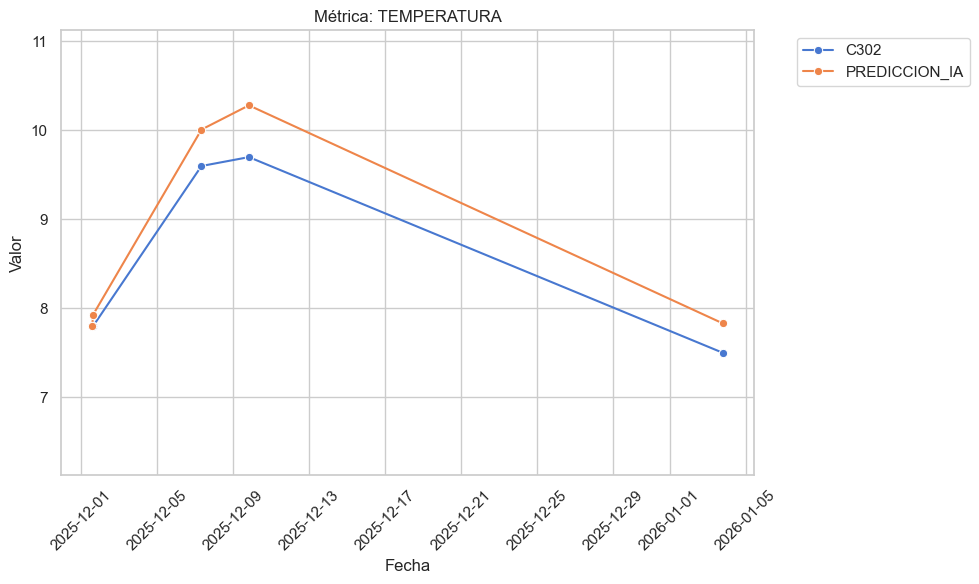

In [1332]:
df_pred_viz = pd.DataFrame({
    'timestamp': y_test.index,
    'value': y_pred,
    'sensor_id': f"PREDICCION_IA",
    'metric': METRIC,
    'batch': 'TEST'
})

# Seleccionamos la realidad para comparar
df_real_viz = df_toy[df_toy['timestamp'].isin(y_test.index) & (df_toy['sensor_id'] == TARGET_ID)].copy()

# Unimos
df_final_viz = pd.concat([df_real_viz, df_pred_viz])

pintar_graficas(df_final_viz)

El modelo funciona excepcionalmente bien, gracias a la multicolinealidad de los datos de temperatura del río. Es por ello que se han elegido esas 5 variables iniciales.

Procedemos a determinar el algoritmo de imputación:

La estrategia es: Un modelo por Sensor y por "Contexto" (Batch/Segmento).

Funciona así:

1. Identificamos al paciente (Target): El sensor C302 tiene huecos en la variable TEMPERATURA.

2. Buscamos a los médicos (Vecinos): El grafo nos dice que C312 y C329 son los mejores para curarlo.

3. El Entrenamiento (La Facultad de Medicina):
    - Buscamos en el historial de datos de este batch todos los momentos donde Target, C312 y C329 estuvieron vivos a la vez.
    - Con esos datos (pueden ser 500 horas), entrenamos UN modelo Ridge. Ese modelo aprende: "Cuando C312 sube 1 grado, C302 suele subir 0.98 grados".
4. La Cirugía (Imputación): Usamos ese mismo modelo entrenado para rellenar todos los huecos de C302 en ese periodo, siempre que los vecinos tengan datos.

Esto garantiza coherencia matemática en toda la serie y es computacionalmente muy rápido.

In [1333]:
class GraphSpatialImputer:
    def __init__(self, topology_df, spatial_metrics=None):

        self.topology = topology_df
        self.spatial_metrics = spatial_metrics

    def impute_batch(self, df_batch):
        if df_batch.empty:
            return df_batch

        imputed_parts = []

        # Trabajamos sobre una lista de métricas segura
        metrics_to_process = df_batch['metric'].unique()

        for metric in metrics_to_process:
            df_m = df_batch[df_batch['metric'] == metric].copy()

            # --- FILTRO DE SEGURIDAD ---
            # Si la métrica no está permitida, NO la procesamos (ni pivotamos).
            # La guardamos tal cual para ensamblarla después.
            if self.spatial_metrics is not None:
                if metric not in self.spatial_metrics:
                    # imputed_parts.append(df_m) # NO append aquí, para no duplicar.
                    # Simplemente no generamos versión imputada de esto.
                    continue

            # 1. Pivotar
            # Si hay duplicados exactos (timestamp+sensor), pivot falla.
            # Hacemos group mean por seguridad.
            pivot = df_m.groupby(['timestamp', 'sensor_id'])['value'].mean().unstack()

            # Detectar candidatos
            sensors_with_nans = pivot.columns[pivot.isna().any()].tolist()

            if not sensors_with_nans:
                continue

            print(f"   > Métrica {metric}: Analizando {len(sensors_with_nans)} candidatos (Espacial)...")

            for target in sensors_with_nans:
                # Topología
                my_topology = self.topology[self.topology['target_sensor'] == target]
                valid_neighbors = [n for n in my_topology['neighbor_sensor'].unique() if n in pivot.columns]

                if not valid_neighbors: continue

                # Máscara Entrenamiento
                mask_train = pivot[target].notna() & pivot[valid_neighbors].notna().all(axis=1)
                if mask_train.sum() < 12: continue

                y_train = pivot.loc[mask_train, target]
                if y_train.std() < 0.01: continue

                # Máscara Relleno
                mask_fill = pivot[target].isna() & pivot[valid_neighbors].notna().all(axis=1)
                if mask_fill.sum() == 0: continue

                X_train = pivot.loc[mask_train, valid_neighbors]
                if X_train.std().min() < 0.01: continue

                # Modelo
                model = Ridge(alpha=1.0)
                model.fit(X_train, y_train)

                # Predicción
                X_fill = pivot.loc[mask_fill, valid_neighbors]
                predicted_values = model.predict(X_fill)
                pivot.loc[mask_fill, target] = predicted_values

                print(f"      [Reparado] {target}: {mask_fill.sum()} huecos usando vecinos.")

            # 2. Des-pivotar
            df_filled = pivot.stack(future_stack=True).reset_index().rename(columns={0: 'value'})
            df_filled['metric'] = metric

            imputed_parts.append(df_filled)

        # 3. ENSAMBLAJE BLINDADO (Aquí estaba el problema del -21)
        if not imputed_parts:
            return df_batch

        # Concatenamos solo lo que hemos calculado/imputado
        df_imputed_stack = pd.concat(imputed_parts, ignore_index=True)

        # --- combine_first ---
        # 1. Ponemos índices idénticos [time, sensor, metric]
        df_batch_idx = df_batch.set_index(['timestamp', 'sensor_id', 'metric'])
        df_new_idx = df_imputed_stack.set_index(['timestamp', 'sensor_id', 'metric'])

        # 2. Aplicamos: Quédate con df_batch_idx. Si tiene NaN, busca en df_new_idx
        # Esto previene CUALQUIER pérdida de datos originales.
        df_combined = df_batch_idx.combine_first(df_new_idx)

        # 3. Filtrado de Filas Fantasma
        # combine_first agrega filas si df_new tiene cosas que df_batch no.
        # Volvemos a recortar usando el índice original para eliminar "fantasmas".
        df_final = df_combined.loc[df_batch_idx.index].reset_index()

        # 4. Recuperar columnas de metadatos (que combine_first no toca si están en el índice)
        # Como df_batch_idx tiene todas las columnas, al hacer combine_first se preservan
        # si no están en df_new_idx (que solo tiene 'value').

        return df_final

Limpiamos los duplicados

In [1334]:
df_topology_clean = df_topology.sort_values('initial_weight', ascending=False).drop_duplicates(
    subset=['target_sensor', 'neighbor_sensor']
)

In [1335]:
METRICAS_SEGURAS_ESPACIAL = [
    # GRUPO A (Inerciales)
    'TEMPERATURA', 'NIVEL', 'CONDUCTIVIDAD',
    # GRUPO B (Cíclicos Globales)
    'OXIGENO DISUELTO', 'PH', 'CLOROFILA'
]

In [1336]:
imputer = GraphSpatialImputer(df_topology_clean, METRICAS_SEGURAS_ESPACIAL)

In [1337]:
print("Ejecutando Imputación Espacial (Ridge + Grafo)...")
df_final_spatial = imputer.impute_batch(df_clean)

# 4. Verificación
nans_antes = df_clean['value'].isna().sum()
nans_despues = df_final_spatial['value'].isna().sum()

print(f"\n--- INFORME DE MISION ---")
print(f"Huecos iniciales: {nans_antes}")
print(f"Huecos finales:   {nans_despues}")
print(f"Datos salvados: {nans_antes - nans_despues}")

Ejecutando Imputación Espacial (Ridge + Grafo)...
   > Métrica CONDUCTIVIDAD: Analizando 29 candidatos (Espacial)...
   > Métrica OXIGENO DISUELTO: Analizando 27 candidatos (Espacial)...
      [Reparado] C306: 14 huecos usando vecinos.
      [Reparado] C307: 44 huecos usando vecinos.
      [Reparado] C309: 372 huecos usando vecinos.
      [Reparado] C310: 1 huecos usando vecinos.
      [Reparado] C313: 27 huecos usando vecinos.
      [Reparado] C328: 16 huecos usando vecinos.
      [Reparado] C333: 2 huecos usando vecinos.
   > Métrica PH: Analizando 28 candidatos (Espacial)...
      [Reparado] C306: 3 huecos usando vecinos.
      [Reparado] C307: 1 huecos usando vecinos.
      [Reparado] C309: 485 huecos usando vecinos.
      [Reparado] C328: 1 huecos usando vecinos.
   > Métrica TEMPERATURA: Analizando 29 candidatos (Espacial)...
      [Reparado] C306: 5 huecos usando vecinos.
      [Reparado] C307: 4 huecos usando vecinos.
      [Reparado] C309: 371 huecos usando vecinos.
      [Rep

In [1338]:
df_final_spatial[df_final_spatial['metric'] == 'TEMPERATURA']

,timestamp,sensor_id,metric,batch,block_change,block_id,delta_abs,epsilon,hour,is_quiet,...,own_time_diff,prev_timestamp,prev_value,segment_id,severity_rate,stagnation_score,trans_value,unit,value,z_score_abs
6405,2025-10-02 15:00:00+00:00,C302,TEMPERATURA,batch1,True,572.0,NaN,0.1,15.0,False,...,NaT,NaT,NaN,1.0,1.0,NaN,18.2,ºC,18.2,0.582239
6406,2025-10-02 16:00:00+00:00,C302,TEMPERATURA,batch1,False,572.0,0.1,0.1,16.0,False,...,0 days 01:00:00,2025-10-02 15:00:00+00:00,18.2,1.0,1.0,NaN,18.3,ºC,18.3,0.869670
6407,2025-10-02 17:00:00+00:00,C302,TEMPERATURA,batch1,False,572.0,0.2,0.1,17.0,False,...,0 days 01:00:00,2025-10-02 16:00:00+00:00,18.3,1.0,1.0,NaN,18.5,ºC,18.5,1.431926
6408,2025-10-02 18:00:00+00:00,C302,TEMPERATURA,batch1,True,573.0,0.0,0.1,18.0,True,...,0 days 01:00:00,2025-10-02 17:00:00+00:00,18.5,1.0,1.0,1.0,18.5,ºC,18.5,1.419208
6409,2025-10-02 19:00:00+00:00,C302,TEMPERATURA,batch1,True,574.0,0.1,0.1,19.0,False,...,0 days 01:00:00,2025-10-02 18:00:00+00:00,18.5,1.0,1.0,NaN,18.6,ºC,18.6,1.697698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276750,2026-01-13 15:00:00+00:00,C345,TEMPERATURA,batch10,False,48238.0,NaN,NaN,15.0,False,...,0 days 01:00:00,2026-01-13 14:00:00+00:00,NaN,234.0,NaN,NaN,0.0,ºC,NaN,0.000000
276751,2026-01-13 16:00:00+00:00,C345,TEMPERATURA,batch10,False,48238.0,NaN,NaN,16.0,False,...,0 days 01:00:00,2026-01-13 15:00:00+00:00,NaN,234.0,NaN,NaN,0.0,ºC,NaN,0.000000
276752,2026-01-13 17:00:00+00:00,C345,TEMPERATURA,batch10,False,48238.0,NaN,NaN,17.0,False,...,0 days 01:00:00,2026-01-13 16:00:00+00:00,NaN,234.0,NaN,NaN,0.0,ºC,NaN,0.000000
276753,2026-01-13 18:00:00+00:00,C345,TEMPERATURA,batch10,False,48238.0,NaN,NaN,18.0,False,...,0 days 01:00:00,2026-01-13 17:00:00+00:00,NaN,234.0,NaN,NaN,0.0,ºC,NaN,0.000000


In [1339]:
fecha_inicio = '2025-10-08 00:00:00+00:00'
fecha_fin = '2025-10-11 23:59:59+00:00'

df_scored[
    (df_scored['batch'] == 'batch1') &
    (df_scored['sensor_id'] == 'C323') &
    (df_scored['metric'] == 'TEMPERATURA') &
    (df_scored['timestamp'] >= fecha_inicio) &
    (df_scored['timestamp'] <= fecha_fin)
    ][['timestamp', 'value', 'sensor_id', 'metric', 'stagnation_score']]

,timestamp,value,sensor_id,metric,stagnation_score
152221,2025-10-08 00:00:00+00:00,15.2,C323,TEMPERATURA,5.0
152229,2025-10-08 01:00:00+00:00,15.2,C323,TEMPERATURA,6.0
152237,2025-10-08 02:00:00+00:00,15.2,C323,TEMPERATURA,7.0
152245,2025-10-08 03:00:00+00:00,15.2,C323,TEMPERATURA,8.0
152253,2025-10-08 04:00:00+00:00,15.2,C323,TEMPERATURA,9.0
...,...,...,...,...,...
152949,2025-10-11 19:00:00+00:00,14.9,C323,TEMPERATURA,NaN
152957,2025-10-11 20:00:00+00:00,15.0,C323,TEMPERATURA,NaN
152965,2025-10-11 21:00:00+00:00,14.9,C323,TEMPERATURA,NaN
152973,2025-10-11 22:00:00+00:00,14.9,C323,TEMPERATURA,1.0


Nuestro imputador es extremadamente minucioso a la hora de reconstruir los datos. Pero no podemos dejar tantos huecos en los datos

In [1340]:
def visualizar_ranking_imputacion(df_merged, mask_imputed, topology_df, posicion=1):
    """
    Navega por el ranking y DEVUELVE los datos para inspección.
    Retorna: (df_imputados, df_contexto_zoom)
    """

    # 1. GENERAR RANKING
    df_only_new = df_merged[mask_imputed]

    if df_only_new.empty:
        print("No hay datos imputados.")
        return None, None

    # Ranking
    ranking = df_only_new.groupby(['sensor_id', 'metric']).size().sort_values(ascending=False)

    total_casos = len(ranking)
    idx = posicion - 1

    if idx < 0 or idx >= total_casos:
        print(f"Posición {posicion} fuera de rango. Hay {total_casos} casos.")
        return None, None

    champion_sensor, champion_metric = ranking.index[idx]
    count = ranking.iloc[idx]

    print(f"--- CASO #{posicion} DEL RANKING ---")
    print(f"SENSOR: {champion_sensor} | MÉTRICA: {champion_metric}")
    print(f"PUNTOS RECUPERADOS: {count}")

    # 2. DEFINIR ZOOM TEMPORAL
    ts_nuevos = df_only_new[
        (df_only_new['sensor_id'] == champion_sensor) &
        (df_only_new['metric'] == champion_metric)
        ]['timestamp']

    if ts_nuevos.empty:
        print("Error buscando timestamps.")
        return None, None

    min_ts, max_ts = ts_nuevos.min(), ts_nuevos.max()

    # Margen de 48h
    start_plot = min_ts - pd.Timedelta(hours=48)
    end_plot = max_ts + pd.Timedelta(hours=48)

    # 3. FILTRAR DATOS ZOOM
    mask_time = (df_merged['timestamp'] >= start_plot) & (df_merged['timestamp'] <= end_plot)
    mask_sensor = (df_merged['sensor_id'] == champion_sensor) & (df_merged['metric'] == champion_metric)

    df_plot = df_merged[mask_sensor & mask_time].sort_values('timestamp')

    # DATOS CRÍTICOS (LOS ROJOS)
    df_reparado = df_plot[df_plot['value_antes'].isna()].copy()

    # 4. FILTRAR VECINOS
    neighbors = topology_df[topology_df['target_sensor'] == champion_sensor]['neighbor_sensor'].unique()

    df_neigh = df_merged[
        (df_merged['sensor_id'].isin(neighbors)) &
        (df_merged['metric'] == champion_metric) &
        mask_time
        ].sort_values('timestamp')

    # 5. GRAFICAR
    fig, ax = plt.subplots(figsize=(14, 7))

    # A. VECINOS
    if not df_neigh.empty:
        sns.lineplot(data=df_neigh, x='timestamp', y='value', hue='sensor_id',
                     palette='Greys', alpha=0.3, legend=False, linewidth=1, ax=ax)
        ax.plot([], [], color='gray', alpha=0.5, label='Vecinos')

    # B. LÍNEA CONTINUIDAD (Roja fina)
    ax.plot(df_plot['timestamp'], df_plot['value'],
            color='red', linestyle='--', linewidth=1, alpha=0.6, label='Continuidad IA')

    # C. DATO ORIGINAL (Azul con marcadores)
    ax.plot(df_plot['timestamp'], df_plot['value_antes'],
            color='royalblue', label='Dato Original',
            linewidth=2.5, marker='.', markersize=5, zorder=5)

    # D. DATO IMPUTADO (Puntos Rojos)
    ax.scatter(df_reparado['timestamp'], df_reparado['value'],
               color='red', s=50, label='Imputación',
               zorder=10, edgecolors='white', linewidth=0.8)

    ax.set_title(f"Reconstrucción #{posicion}: {champion_sensor} - {champion_metric}\n{min_ts} a {max_ts}", fontsize=12)
    ax.set_ylabel(champion_metric)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    fig.autofmt_xdate()

    plt.show()

    return df_reparado, df_plot

In [1341]:
def auditoria_blindada(df_antes, df_despues):
    print("--- AUDITORÍA BLINDADA (Comparando Antes vs Después) ---")

    # Unimos por las claves únicas para evitar errores de índice
    df_merged = pd.merge(
        df_despues,
        df_antes[['timestamp', 'sensor_id', 'metric', 'value']],
        on=['timestamp', 'sensor_id', 'metric'],
        how='left',
        suffixes=('', '_antes')
    )

    # La máscara detecta: Donde ANTES era NaN Y AHORA hay dato
    mask_real_imputation = df_merged['value_antes'].isna() & df_merged['value'].notna()

    total_reparados = mask_real_imputation.sum()
    print(f"Puntos recuperados: {total_reparados}")

    return df_merged, mask_real_imputation

--- AUDITORÍA BLINDADA (Comparando Antes vs Después) ---
Puntos recuperados: 1499
--- CASO #5 DEL RANKING ---
SENSOR: C307 | MÉTRICA: OXIGENO DISUELTO
PUNTOS RECUPERADOS: 44


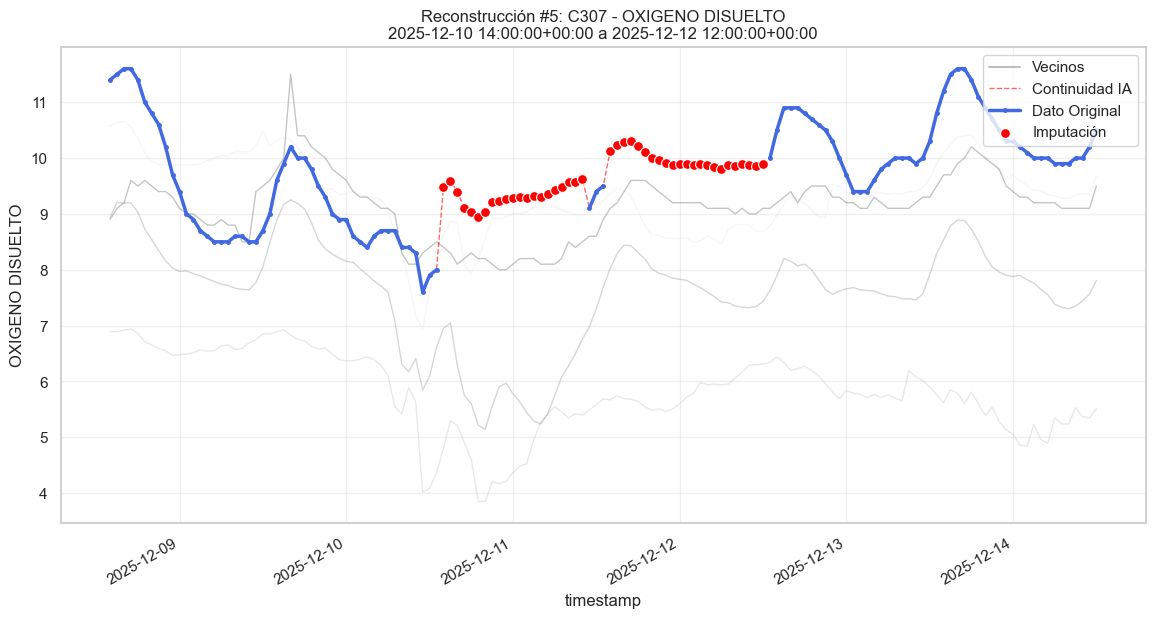


--- INSPECCIÓN DE DATOS IMPUTADOS (PUNTOS ROJOS) ---
                      timestamp sensor_id            metric  value_antes  \
46935 2025-12-10 14:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46936 2025-12-10 15:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46937 2025-12-10 16:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46938 2025-12-10 17:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46939 2025-12-10 18:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46940 2025-12-10 19:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46941 2025-12-10 20:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46942 2025-12-10 21:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46943 2025-12-10 22:00:00+00:00      C307  OXIGENO DISUELTO          NaN   
46944 2025-12-10 23:00:00+00:00      C307  OXIGENO DISUELTO          NaN   

          value  
46935  9.489587  
46936  9.593835  
46937  9.397016  
46938  9.097899  
46939  9.030736  
4

In [1342]:
df_auditoria, mask_auditoria = auditoria_blindada(df_clean, df_final_spatial)
# Ejecutamos y capturamos los datos
puntos_rojos, contexto_total = visualizar_ranking_imputacion(
    df_auditoria, mask_auditoria, df_topology_clean, posicion=5
)

if puntos_rojos is not None:
    print("\n--- INSPECCIÓN DE DATOS IMPUTADOS (PUNTOS ROJOS) ---")
    # Mostramos las primeras filas de lo que se ha inventado la IA
    print(puntos_rojos[['timestamp', 'sensor_id', 'metric', 'value_antes', 'value']].head(10))

    print("\n--- ESTADÍSTICAS DE LA IMPUTACIÓN ---")
    print(puntos_rojos['value'].describe())

# Multivariate Imputation by Chained Equations

Viendo que todavía quedan muchos puntos por inputar, vamos a subir el poder de inferencia con Multivariate Imputation by Chained Equations (MICE)

Elegimos el modelo BayesianRidge (regresión lineal probabilística) porque tenemos un problema fuertemente condicionado por la multicolinealidad de las variables. Además, nos conviene que el modelo sea bueno extrapolando las tendencias. También es de gran ayuda que sea explicable.

En un XGBoost XGBoost

 Los árboles eligen la mejor variable para cortar y descartan las demás en ese nodo.

 Ante variables muy correlacionadas, XGBoost elige una al azar y mata la influencia de las otras. Esto hace que el modelo sea inestable si los datos tienen huecos (porque si falta la variable "elegida", el árbol colapsa).

Defecto fatal en series temporales: Los árboles NO EXTRAPOLAN. Si el río sube a un nivel histórico nunca visto en el entrenamiento, XGBoost predecirá el valor máximo que vio en el pasado (una línea plana), cortando el pico real.


Para fenómenos físicos continuos (hidrología), BayesianRidge > XGBoost. XGBoost es mejor para cosas no lineales complejas (como predecir si un cliente comprará un producto), pero para rellenar curvas suaves, la regresión bayesiana es la reina.

Pivotar (Time x Sensor_Metric)

In [1343]:
ratio_huecos = 0.2

pivot = df_clean.pivot(index='timestamp', columns=['sensor_id', 'metric'], values='value')

SELECCIÓN DE CANDIDATOS
Para la validación necesitamos datos reales (Ground Truth).
Seleccionamos las 15 columnas con más datos para maximizar la intersección.

In [1344]:
conteo = pivot.notna().sum().sort_values(ascending=False)
top_cols = conteo.head(15).index
data_subset = pivot[top_cols]


Borramos filas que tengan huecos en este subset para tener la verdad

In [1345]:
data_truth = data_subset.dropna()

if data_truth.shape[0] < 50:
    print(f"Error: Aún seleccionando los mejores, solo tenemos {data_truth.shape[0]} filas comunes.")
    print("Intenta bajar el umbral de exigencia o usa un periodo de tiempo más corto.")

print(f"   Dataset de Validación: {data_truth.shape} (Filas x Variables)")

   Dataset de Validación: (1280, 15) (Filas x Variables)


 GENERAR HUECOS ARTIFICIALES (MÁSCARA)

In [1346]:
np.random.seed(42)
mask_artificial = np.random.rand(*data_truth.shape) < ratio_huecos

data_corrupted = data_truth.copy()
data_corrupted[mask_artificial] = np.nan

Usamos BayesianRidge por su robustez ante multicolinealidad

In [1347]:
model = BayesianRidge()
imputer = IterativeImputer(estimator=model, max_iter=20, random_state=42, verbose=0)

data_imputed = imputer.fit_transform(data_corrupted)

/home/duo/Projects/InstructLab_test_for_uni/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:867: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Extraemos solo los valores que borramos para comparar Realidad vs Predicción

In [1348]:
truth_vec = data_truth.values[mask_artificial]
imp_vec = data_imputed[mask_artificial]

r2_global = r2_score(truth_vec, imp_vec)
mae_global = mean_absolute_error(truth_vec, imp_vec)

print(f"   RESULTADO GLOBAL BAYESIAN RIDGE:")
print(f"      R2 Score: {r2_global:.4f} (Objetivo > 0.80)")
print(f"      MAE:      {mae_global:.4f}")

   RESULTADO GLOBAL BAYESIAN RIDGE:
      R2 Score: 0.9894 (Objetivo > 0.80)
      MAE:      0.2594


EVALUACIÓN DETALLADA POR VARIABLE (EL DESGLOSE)


   --- DESGLOSE POR VARIABLE (Ranking de Predictibilidad) ---
   C316-TEMPERATURA      : R2=0.9910 | MAE=0.2143  |||||||||||||||||||
   C312-TEMPERATURA      : R2=0.9902 | MAE=0.3227  |||||||||||||||||||
   C302-OXIGENO DISUELTO : R2=0.9786 | MAE=0.1453  |||||||||||||||||||
   C326-TEMPERATURA      : R2=0.9719 | MAE=0.4326  |||||||||||||||||||
   C304-TEMPERATURA      : R2=0.9715 | MAE=0.3943  |||||||||||||||||||
   C326-OXIGENO DISUELTO : R2=0.9547 | MAE=0.1607  |||||||||||||||||||
   C316-OXIGENO DISUELTO : R2=0.9495 | MAE=0.1142  ||||||||||||||||||
   C326-PH               : R2=0.9017 | MAE=0.0515  ||||||||||||||||||
   C303-OXIGENO DISUELTO : R2=0.8582 | MAE=0.3426  |||||||||||||||||
   C342-OXIGENO DISUELTO : R2=0.6643 | MAE=0.4847  |||||||||||||
   C303-CLOROFILA        : R2=0.5363 | MAE=0.1535  ||||||||||
   C304-OXIGENO DISUELTO : R2=0.4827 | MAE=0.8583  |||||||||
   C316-NIVEL            : R2=0.4671 | MAE=0.0135  |||||||||
   C323-NIVEL            : R2=0.4415 | MAE=0.0287  ||

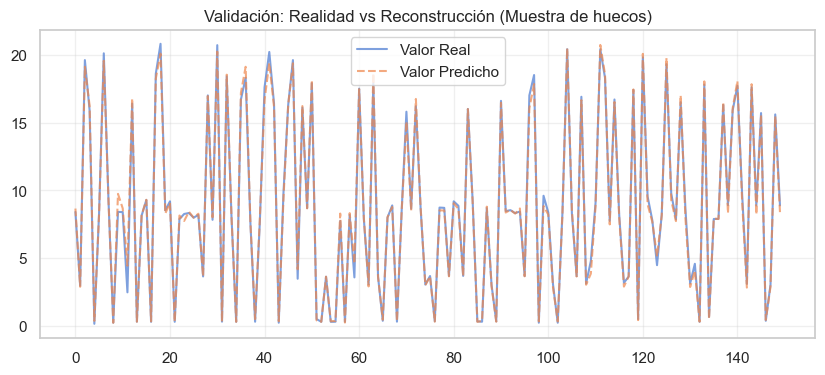

In [1349]:
print("\n   --- DESGLOSE POR VARIABLE (Ranking de Predictibilidad) ---")
metrics_perf = []

for idx, col_name in enumerate(top_cols):
    # Máscara específica para esta columna (dónde hicimos huecos en esta variable)
    mask_col = mask_artificial[:, idx]

    if mask_col.sum() == 0:
        continue  # No se borró nada en esta columna, saltamos

    # Valores reales de esa columna
    truth_col = data_truth.iloc[:, idx].values[mask_col]

    # Valores imputados de esa columna
    # data_imputed es un array numpy, accedemos por índice
    col_imputed_full = data_imputed[:, idx]
    vals_imputed = col_imputed_full[mask_col]

    score = r2_score(truth_col, vals_imputed)
    mae_col = mean_absolute_error(truth_col, vals_imputed)
    metrics_perf.append((col_name, score, mae_col))

# Ordenamos por R2 descendente (los mejores arriba)
metrics_perf.sort(key=lambda x: x[1], reverse=True)

for (sensor, metric), score, mae in metrics_perf:
    # Barra visual ASCII
    bar_len = int(score * 20) if score > 0 else 0
    bar = "|" * bar_len
    print(f"   {sensor}-{metric: <16} : R2={score:.4f} | MAE={mae:.4f}  {bar}")

# GRÁFICA DE VALIDACIÓN (Fragmento)
plt.figure(figsize=(10, 4))
# Pintamos los primeros 150 puntos recuperados (aplanados) para ver el ajuste visual
limit = min(150, len(truth_vec))
plt.plot(truth_vec[:limit], label='Valor Real', alpha=0.7)
plt.plot(imp_vec[:limit], label='Valor Predicho', alpha=0.7, linestyle='--')
plt.title("Validación: Realidad vs Reconstrucción (Muestra de huecos)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Tras el entrenamiento e inferencia inicial podemos sacar las siguientes conclusiones:

La Orquesta (Temp, Oxígeno, pH): Tienen R2 > 0.90 porque tocan la misma música (el ciclo solar/biológico). Si sabes la temperatura, sabes el oxígeno. MICE funciona de lujo aquí.

Los Solistas (Nivel): El nivel del agua depende de si llueve en la cabecera o si abren una presa. No tiene nada que ver con si las algas están haciendo fotosíntesis (pH/Oxígeno). Por eso el modelo falla (R2 = 0.46).

El Ruido (Ficocianinas): R2 negativo (-0.06). Esto significa que el modelo es peor que simplemente usar la media. Es basura. Probablemente son trazas tan pequeñas y ruidosas que intentar predecirlas con otras variables solo introduce error.

Por lo que vamos a definir dos grupos:
GRUPO A: La Élite Multivariante (Temp, OD, pH, Nutrientes, Turbidez).
* Estrategia: MICE (BayesianRidge). Usamos la potencia bruta porque se ayudan entre sí.

GRUPO B: Los Independientes (Nivel, Ficocianinas, Clorofila).
* Estrategia: Smart Infilling (Temporal). Como no correlacionan con los demás, lo mejor es confiar en su propia inercia temporal (si el nivel estaba en 2m hace una hora, estará cerca de 2m ahora).

Necesitamos que la función nos devuelva también el grupo de estaciones y métricas, para hacer una inferencia fiable

In [1350]:
def clasificar_sensores_mice_robusto(df_clean, r2_threshold=0.7, top_n=40):
    """
    Clasifica sensores en Grupo A (MICE) o Grupo B (Smart Infill).
    CORREGIDO: Usa resample para alinear tiempos y limita al Top N para asegurar intersección.
    """
    print(f"--- 🩺 CLASIFICACIÓN ROBUSTA (Top {top_n} Densos | R2 > {r2_threshold}) ---")

    # 1. PIVOTAR Y ALINEAR (Resample es CLAVE para que coincidan filas)
    # Agrupamos por hora (o el periodo que uses) para maximizar coincidencias
    pivot = df_clean.pivot(index='timestamp', columns=['sensor_id', 'metric'], values='value')
    pivot = pivot.resample('1h').mean()  # Ajusta a '30min' si prefieres

    # 2. SELECCIÓN DEL NÚCLEO (Top N columnas con más datos)
    conteo = pivot.notna().sum().sort_values(ascending=False)

    # Solo intentamos validar los N mejores. El resto va directo a Grupo B.
    cols_candidatas = conteo.head(top_n).index
    cols_descartadas = conteo.iloc[top_n:].index.tolist()

    data_subset = pivot[cols_candidatas]

    # 3. GROUND TRUTH (Filas donde el Núcleo coincide)
    # Permitimos filas que tengan al menos el 80% de los datos del núcleo
    thresh = int(len(cols_candidatas) * 0.8)
    data_truth = data_subset.dropna(thresh=thresh)

    # Rellenamos los huecos pequeños restantes en el Ground Truth con interpolación
    # para poder usarlo como "Verdad" completa en el test de borrado
    data_truth = data_truth.interpolate(limit_direction='both')
    data_truth = data_truth.dropna()  # Limpieza final de bordes

    if data_truth.shape[0] < 50:
        print(f"Error: Incluso con el Top {top_n}, solo coinciden {data_truth.shape[0]} filas.")
        print("   -> Reduciendo ambición: validando solo Top 15...")
        # Fallback de emergencia
        return clasificar_sensores_mice_robusto(df_clean, r2_threshold, top_n=15)

    print(f"   Base de validación: {data_truth.shape} (Filas x Variables)")

    # 4. CORRUPCIÓN (Borramos el 20% al azar)
    np.random.seed(42)
    mask_artificial = np.random.rand(*data_truth.shape) < 0.2
    data_corrupted = data_truth.copy()
    data_corrupted[mask_artificial] = np.nan

    # 5. TEST MICE
    model = BayesianRidge()
    imputer = IterativeImputer(estimator=model, max_iter=20, random_state=42, verbose=0)

    try:
        # Entrenamos solo con el núcleo
        data_imputed = imputer.fit_transform(data_corrupted)

        mice_whitelist = []
        smart_infill_list = cols_descartadas  # Empezamos con los que ya descartamos

        results = []

        # Evaluamos columna a columna
        # data_truth.columns son las cols_candidatas
        for idx, col_tuple in enumerate(data_truth.columns):
            sensor, metric = col_tuple

            mask_col = mask_artificial[:, idx]
            if mask_col.sum() == 0: continue

            truth_vec = data_truth.iloc[:, idx].values[mask_col]
            imp_vec = data_imputed[:, idx][mask_col]

            score = r2_score(truth_vec, imp_vec)
            results.append((sensor, metric, score))

            if score >= r2_threshold:
                mice_whitelist.append((sensor, metric))
            else:
                smart_infill_list.append((sensor, metric))

        # 6. REPORTE
        results.sort(key=lambda x: x[2], reverse=True)

        print(f"\nGRUPO A (MICE - Élite): {len(mice_whitelist)} sensores")
        for s, m, r in results[:10]:  # Top 10 ejemplos
            if r >= r2_threshold: print(f"      {s}-{m}: {r:.3f}")

        print(f"\nGRUPO B (Smart Infill): {len(smart_infill_list)} sensores (Bajo R2 o Dispersos)")
        # Mostramos algunos fallos del núcleo
        for s, m, r in results:
            if r < r2_threshold: print(f"      {s}-{m}: {r:.3f} (Falló test)")

        return mice_whitelist, smart_infill_list

    except Exception as e:
        print(f"Error: {e}")
        return [], []  # Fallback a todo vacío

In [1351]:
lista_vip, lista_rechazados = clasificar_sensores_mice_robusto(df_clean, r2_threshold=0.7, top_n=40)

--- 🩺 CLASIFICACIÓN ROBUSTA (Top 40 Densos | R2 > 0.7) ---
   Base de validación: (1281, 40) (Filas x Variables)

GRUPO A (MICE - Élite): 28 sensores
      C312-TEMPERATURA: 0.997
      C328-TEMPERATURA: 0.996
      C316-TEMPERATURA: 0.996
      C310-TEMPERATURA: 0.995
      C333-TEMPERATURA: 0.988
      C302-OXIGENO DISUELTO: 0.985
      C326-TEMPERATURA: 0.982
      C304-TEMPERATURA: 0.982
      C306-TEMPERATURA: 0.978
      C316-OXIGENO DISUELTO: 0.977

GRUPO B (Smart Infill): 189 sensores (Bajo R2 o Dispersos)
      C316-NIVEL: 0.695 (Falló test)
      C326-TURBIDEZ: 0.651 (Falló test)
      C307-NIVEL: 0.633 (Falló test)
      C333-TURBIDEZ: 0.501 (Falló test)
      C323-NIVEL: 0.491 (Falló test)
      C306-CARBONO ORGANICO: 0.484 (Falló test)
      C306-OXIGENO DISUELTO: 0.460 (Falló test)
      C333-OXIGENO DISUELTO: 0.434 (Falló test)
      C344-FICOCIANINAS: 0.426 (Falló test)
      C344-TURBIDEZ: 0.317 (Falló test)
      C306-PH: 0.282 (Falló test)
      C306-NIVEL: -0.034 (F

/home/duo/Projects/InstructLab_test_for_uni/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:867: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Ahora sí podemos imputar con confianza de no inventarnos datos raros

In [1352]:
class MultivariateImputerFino:
    def __init__(self, max_iter=50, random_state=42):
        self.estimator = BayesianRidge()
        self.max_iter = max_iter
        self.random_state = random_state

    def impute_batch(self, df_batch, target_pairs=None):
        # 0. Chequeos de seguridad
        if df_batch.empty or not target_pairs:
            return df_batch

        print(f"🤖 MICE Fino: Procesando {len(target_pairs)} pares VIP...")

        # 1. PREPARAR EL TERRENO (Indexación)
        # Ponemos el DF original en modo índice para protegerlo
        df_indexed = df_batch.set_index(['timestamp', 'sensor_id', 'metric'])

        # 2. PIVOTAR (Solo values)
        # Usamos pivot_table por seguridad contra duplicados
        pivot = df_batch.pivot_table(index='timestamp', columns=['sensor_id', 'metric'], values='value', aggfunc='mean')

        # 3. SELECCIÓN DE VIPs
        cols_vip = [col for col in pivot.columns if col in target_pairs]
        if not cols_vip:
            return df_batch

        # Subset para MICE
        pivot_process = pivot[cols_vip].dropna(axis=1, how='all')
        if pivot_process.empty:
            return df_batch

        # 4. MICE (Imputación)
        imputer = IterativeImputer(
            estimator=self.estimator,
            max_iter=self.max_iter,
            random_state=self.random_state,
            initial_strategy='mean',
            verbose=0,
            tol=1e-3
        )

        try:
            matrix_imputed = imputer.fit_transform(pivot_process)
        except Exception as e:
            print(f"   ❌ Error MICE: {e}")
            return df_batch

        # 5. CREAR EL "PARCHE"
        # Convertimos la matriz imputada de vuelta a formato Serie con índice MultiIndex
        df_imputed_vip = pd.DataFrame(matrix_imputed, index=pivot_process.index, columns=pivot_process.columns)
        patch_series = df_imputed_vip.stack(level=[0, 1], future_stack=True)
        patch_series.index.names = ['timestamp', 'sensor_id', 'metric']
        patch_series.name = 'value'

        # Convertimos a DataFrame para alinear
        df_patch = patch_series.to_frame()

        # combine_first prioriza df_indexed (original). Solo rellena si df_indexed es NaN.
        # Al trabajar por índice, es mucho más robusto que merge() ante micro-diferencias.
        df_result_indexed = df_indexed.combine_first(df_patch)

        # 7. LIMPIEZA FINAL
        # combine_first puede haber añadido filas nuevas (las "filas fantasma" del pivot).
        # Las recortamos quedándonos estrictamente con el índice original.
        df_final = df_result_indexed.loc[df_indexed.index].reset_index()

        # Reporte
        nans_antes = df_batch['value'].isna().sum()
        nans_despues = df_final['value'].isna().sum()
        diff = nans_antes - nans_despues

        print(f"   ✨ MICE Finalizado. Huecos cerrados: {diff}")

        # Verificación de seguridad
        if diff < 0:
            print(f"ALERTA: Se han perdido {-diff} datos. Esto no debería pasar con combine_first.")

        return df_final

A continuación la implementación del SmartInfillingCleaner siguiendo las políticas de calidad de datos definidas en el cuaderno serialización parquet

In [1353]:
class SmartTimeImputer:
    def __init__(self, freq_minutes=60):
        self.freq_minutes = freq_minutes

        # Estructura: (Metodo, Orden_Spline, Gap_Max_Horas)
        self.STRATEGIES = {
            'TEMPERATURA': ('time', None, 6),
            'NIVEL': ('time', None, 6),
            'CONDUCTIVIDAD': ('time', None, 6),
            'OXIGENO DISUELTO': ('spline', 3, 3),
            'CLOROFILA': ('time', 3, 3),
            'FICOCIANINAS': ('spline', 3, 3),
            'PH': ('time', 3, 3),
            'TURBIDEZ': ('time', None, 2),
            'AMONIO': ('time', None, 2),
            'NITRATOS': ('time', None, 2),
            'FOSFATOS': ('time', None, 2),
            'CARBONO ORGANICO': ('time', None, 2)
        }

    def _get_limit_rows(self, hours):
        return int((hours * 60) / self.freq_minutes)

    def impute(self, df_input):
        print("--- START SMART TIME IMPUTER (TIME-BASED) ---")

        final_dfs = []
        df_work = df_input.copy()

        # Asegurar formato datetime para el calculo de distancias temporales
        df_work['timestamp'] = pd.to_datetime(df_work['timestamp'])

        for metric in df_work['metric'].unique():
            df_m = df_work[df_work['metric'] == metric].copy()
            df_m_indexed = df_m.set_index(['timestamp', 'sensor_id'])

            if metric not in self.STRATEGIES:
                final_dfs.append(df_m)
                continue

            method, order, gap_hours = self.STRATEGIES[metric]
            limit_rows = self._get_limit_rows(gap_hours)

            # Pivotar para obtener DatetimeIndex en las filas
            pivot = df_m.pivot(index='timestamp', columns='sensor_id', values='value')

            try:
                if method == 'spline':
                    # Spline no soporta 'time' directamente como argumento de metodo,
                    # pero al tener DatetimeIndex, respeta la proporcion temporal.
                    pivot_filled = pivot.interpolate(method='spline', order=order, limit=limit_rows,
                                                     limit_direction='both')
                else:
                    # El metodo 'time' requiere que el indice sea DatetimeIndex
                    pivot_filled = pivot.interpolate(method='time', limit=limit_rows, limit_direction='both')
            except Exception as e:
                print(f"   Error en {metric}: {e}")
                pivot_filled = pivot

            # Generacion de parche y alineacion por indice
            patch_series = pivot_filled.stack(future_stack=True)
            patch_series.name = 'value'
            df_patch = patch_series.to_frame()
            df_patch.index.names = ['timestamp', 'sensor_id']

            # combine_first prioriza el dato original y rellena huecos
            df_restored = df_m_indexed.combine_first(df_patch)

            # Recortar filas fantasma usando el indice original
            df_final_metric = df_restored.loc[df_m_indexed.index].reset_index()
            df_final_metric['metric'] = metric

            # Restauracion de metadatos mediante merge left
            cols_meta = [c for c in df_m.columns if c not in ['timestamp', 'sensor_id', 'metric', 'value']]
            if cols_meta:
                meta_ref = df_m[['timestamp', 'sensor_id'] + cols_meta].drop_duplicates()
                df_final_metric = pd.merge(df_final_metric, meta_ref, on=['timestamp', 'sensor_id'], how='left')

            nans_pre = df_m['value'].isna().sum()
            nans_post = df_final_metric['value'].isna().sum()
            if nans_pre > nans_post:
                print(f"   [{metric}] {method.upper()} (Gap {gap_hours}h): {nans_pre - nans_post} recuperados.")

            final_dfs.append(df_final_metric)

        df_final = pd.concat(final_dfs, ignore_index=True)
        if 'batch' in df_final.columns:
            df_final.sort_values(['sensor_id', 'metric', 'timestamp'], inplace=True)

        return df_final

Pipeline completo SPATIAL + MICE + SMART INFILLING

Motor 1: Arreglar fallos de sensor usando sensores adyacentes.

In [1354]:
huecos_iniciales = df_clean['value'].isna().sum()

In [1355]:
spatial_imputer = GraphSpatialImputer(df_topology_clean, METRICAS_SEGURAS_ESPACIAL)
df_fase1 = spatial_imputer.impute_batch(df_clean)

   > Métrica CONDUCTIVIDAD: Analizando 29 candidatos (Espacial)...
   > Métrica OXIGENO DISUELTO: Analizando 27 candidatos (Espacial)...
      [Reparado] C306: 14 huecos usando vecinos.
      [Reparado] C307: 44 huecos usando vecinos.
      [Reparado] C309: 372 huecos usando vecinos.
      [Reparado] C310: 1 huecos usando vecinos.
      [Reparado] C313: 27 huecos usando vecinos.
      [Reparado] C328: 16 huecos usando vecinos.
      [Reparado] C333: 2 huecos usando vecinos.
   > Métrica PH: Analizando 28 candidatos (Espacial)...
      [Reparado] C306: 3 huecos usando vecinos.
      [Reparado] C307: 1 huecos usando vecinos.
      [Reparado] C309: 485 huecos usando vecinos.
      [Reparado] C328: 1 huecos usando vecinos.
   > Métrica TEMPERATURA: Analizando 29 candidatos (Espacial)...
      [Reparado] C306: 5 huecos usando vecinos.
      [Reparado] C307: 4 huecos usando vecinos.
      [Reparado] C309: 371 huecos usando vecinos.
      [Reparado] C310: 1 huecos usando vecinos.
      [Repar

In [1356]:
h_f1 = df_fase1['value'].isna().sum()
recup_f1 = huecos_iniciales - h_f1
print(f"Fase 1 completada. Recuperados: {recup_f1} datos.")

Fase 1 completada. Recuperados: 1499 datos.


Motor 2: MICE Fino (Solo toca lo que le digamos). Usamos 50 iteraciones para que converja bien con la matriz compleja

In [1357]:
mice_imputer = MultivariateImputerFino(max_iter=50)

Motor 3: Smart Infilling (Barre todo lo que quede). Max gap de 12h: Si el hueco es mayor, mejor dejarlo vacío que inventar una recta de 2 días.

In [1358]:
time_imputer = SmartTimeImputer(freq_minutes=60)

In [1359]:
print(f"INICIANDO PROCESO DE RECUPERACIÓN HÍBRIDA")
print(f"   Sensores VIP (MICE): {len(lista_vip)} pares.")
print(f"   Pares VIP (MICE): {lista_vip}.")
print(f"   Sensores RECHAZADOS (Temporal): {len(lista_rechazados)} pares.")

INICIANDO PROCESO DE RECUPERACIÓN HÍBRIDA
   Sensores VIP (MICE): 28 pares.
   Pares VIP (MICE): [('C326', 'PH'), ('C342', 'OXIGENO DISUELTO'), ('C326', 'OXIGENO DISUELTO'), ('C326', 'TEMPERATURA'), ('C303', 'OXIGENO DISUELTO'), ('C303', 'CLOROFILA'), ('C304', 'TEMPERATURA'), ('C304', 'OXIGENO DISUELTO'), ('C302', 'OXIGENO DISUELTO'), ('C316', 'TEMPERATURA'), ('C316', 'OXIGENO DISUELTO'), ('C312', 'TEMPERATURA'), ('C333', 'TEMPERATURA'), ('C312', 'OXIGENO DISUELTO'), ('C310', 'OXIGENO DISUELTO'), ('C328', 'PH'), ('C310', 'TEMPERATURA'), ('C344', 'OXIGENO DISUELTO'), ('C307', 'TEMPERATURA'), ('C322', 'OXIGENO DISUELTO'), ('C306', 'TEMPERATURA'), ('C343', 'OXIGENO DISUELTO'), ('C310', 'TURBIDEZ'), ('C328', 'TEMPERATURA'), ('C302', 'TURBIDEZ'), ('C303', 'TURBIDEZ'), ('C328', 'OXIGENO DISUELTO'), ('C313', 'TURBIDEZ')].
   Sensores RECHAZADOS (Temporal): 189 pares.


FASE 2: IMPUTACIÓN MULTIVARIANTE (Solo VIPs)
Pasamos df_clean y la lista_vip.
El imputador ignorará olímpicamente los sensores de la lista de rechazados.

In [1360]:
df_fase2 = mice_imputer.impute_batch(df_fase1, target_pairs=lista_vip)

🤖 MICE Fino: Procesando 28 pares VIP...
   ✨ MICE Finalizado. Huecos cerrados: 86


/home/duo/Projects/InstructLab_test_for_uni/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:867: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


FASE 3: SMART INFILLING TEMPORAL
Este paso cogerá el relevo. Rellenará:

1. Los huecos pequeños que quedaron en los VIPs (si MICE no pudo con todos).
2. TODOS los huecos de los Rechazados (Nivel, Turbidez, C306-Oxigeno, etc).

In [1361]:
df_final = time_imputer.impute(df_fase2)

--- START SMART TIME IMPUTER (TIME-BASED) ---
   [AMONIO] TIME (Gap 2h): 689 recuperados.
   [NITRATOS] TIME (Gap 2h): 138 recuperados.
   [OXIGENO DISUELTO] SPLINE (Gap 3h): 322 recuperados.
   [PH] TIME (Gap 3h): 1560 recuperados.
   [TEMPERATURA] TIME (Gap 6h): 925 recuperados.
   [TURBIDEZ] TIME (Gap 2h): 695 recuperados.
   [CLOROFILA] TIME (Gap 3h): 557 recuperados.
   [FICOCIANINAS] SPLINE (Gap 3h): 327 recuperados.
   [CARBONO ORGANICO] TIME (Gap 2h): 169 recuperados.
   [FOSFATOS] TIME (Gap 2h): 117 recuperados.
   [NIVEL] TIME (Gap 6h): 469 recuperados.


AUDITORÍA FINAL DE RESULTADOS

In [1362]:
print("\n--- INFORME DE MISIÓN ---")
nans_ini = df_clean['value'].isna().sum()
nans_fin = df_final['value'].isna().sum()
recuperados = nans_ini - nans_fin

print(f"   Huecos Iniciales: {nans_ini}")
print(f"   Huecos Finales:   {nans_fin}")
print(f"   DATOS RECUPERADOS: {recuperados}")


--- INFORME DE MISIÓN ---
   Huecos Iniciales: 102069
   Huecos Finales:   94516
   DATOS RECUPERADOS: 7553


Vamos a ver un caso de éxito del MICE (VIP)


Inspeccionando un caso VIP (Imputación Multivariante):
--- AUDITORÍA BLINDADA (Comparando Antes vs Después) ---
Puntos recuperados: 7553
--- CASO #1 DEL RANKING ---
SENSOR: C309 | MÉTRICA: PH
PUNTOS RECUPERADOS: 498


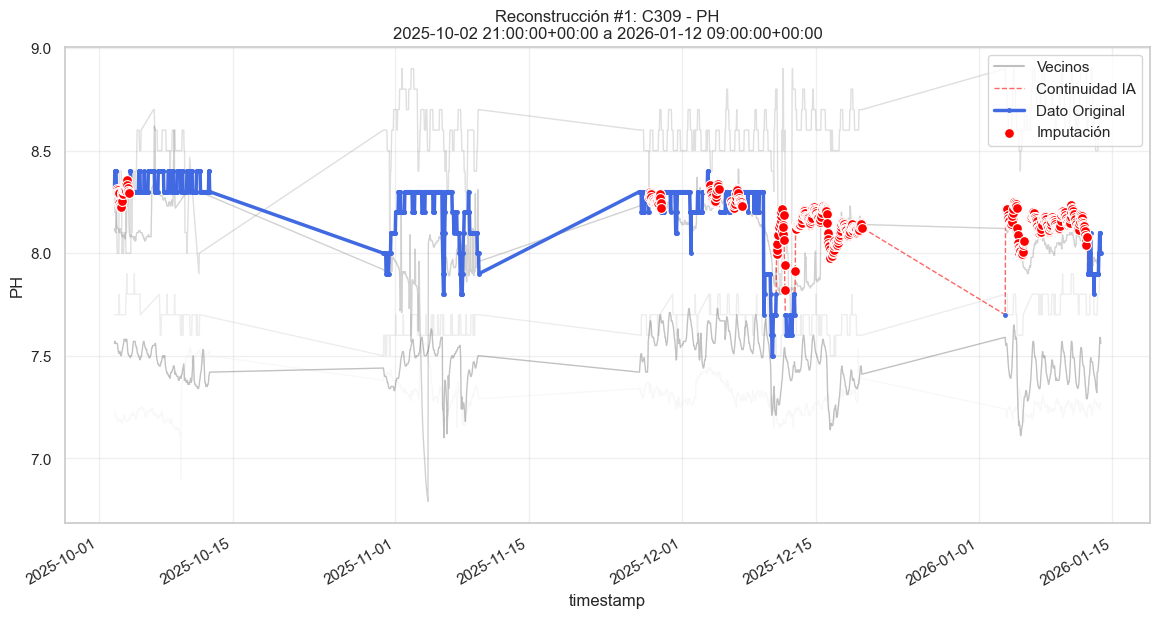

--- CASO #2 DEL RANKING ---
SENSOR: C309 | MÉTRICA: TEMPERATURA
PUNTOS RECUPERADOS: 373


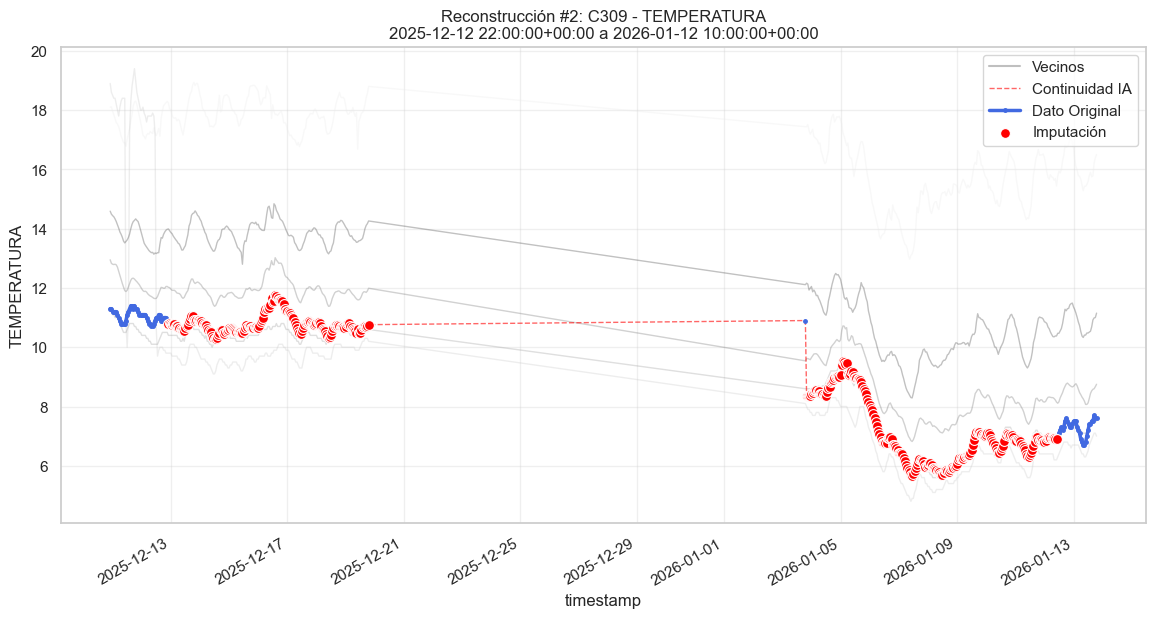

--- CASO #3 DEL RANKING ---
SENSOR: C309 | MÉTRICA: OXIGENO DISUELTO
PUNTOS RECUPERADOS: 372


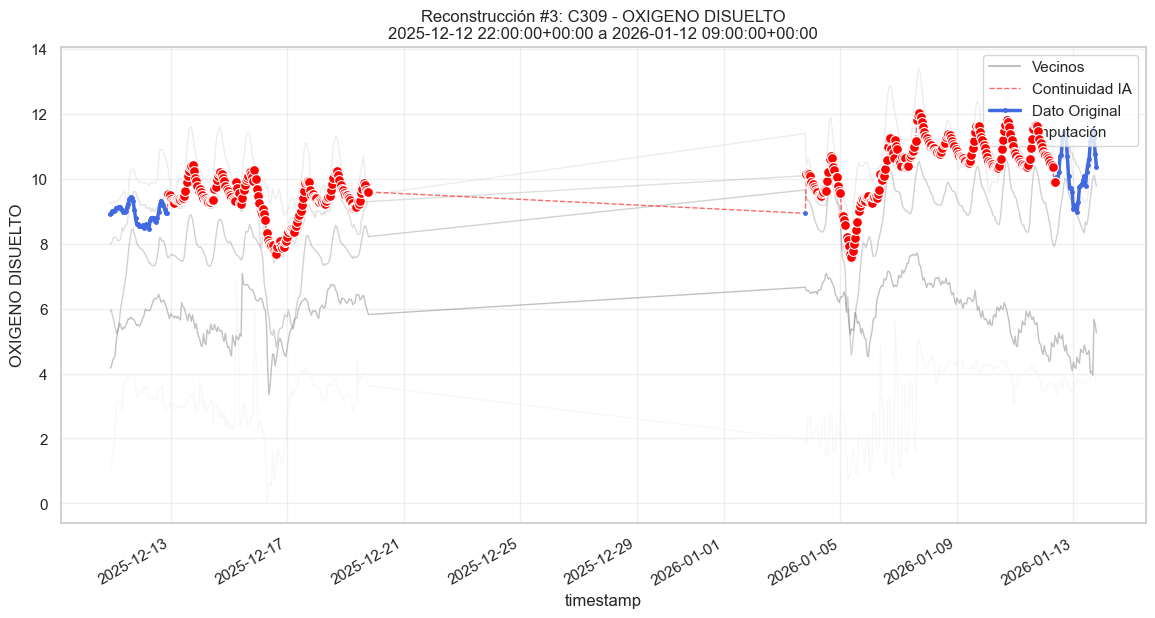

--- CASO #4 DEL RANKING ---
SENSOR: C343 | MÉTRICA: CLOROFILA
PUNTOS RECUPERADOS: 287


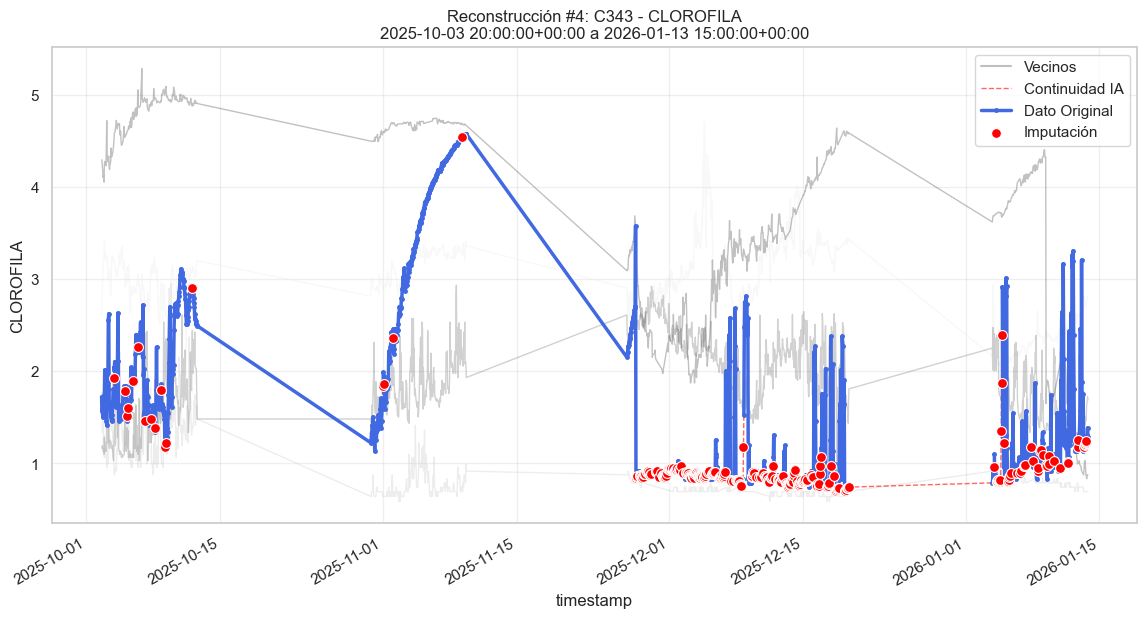

--- CASO #5 DEL RANKING ---
SENSOR: C325 | MÉTRICA: TEMPERATURA
PUNTOS RECUPERADOS: 219


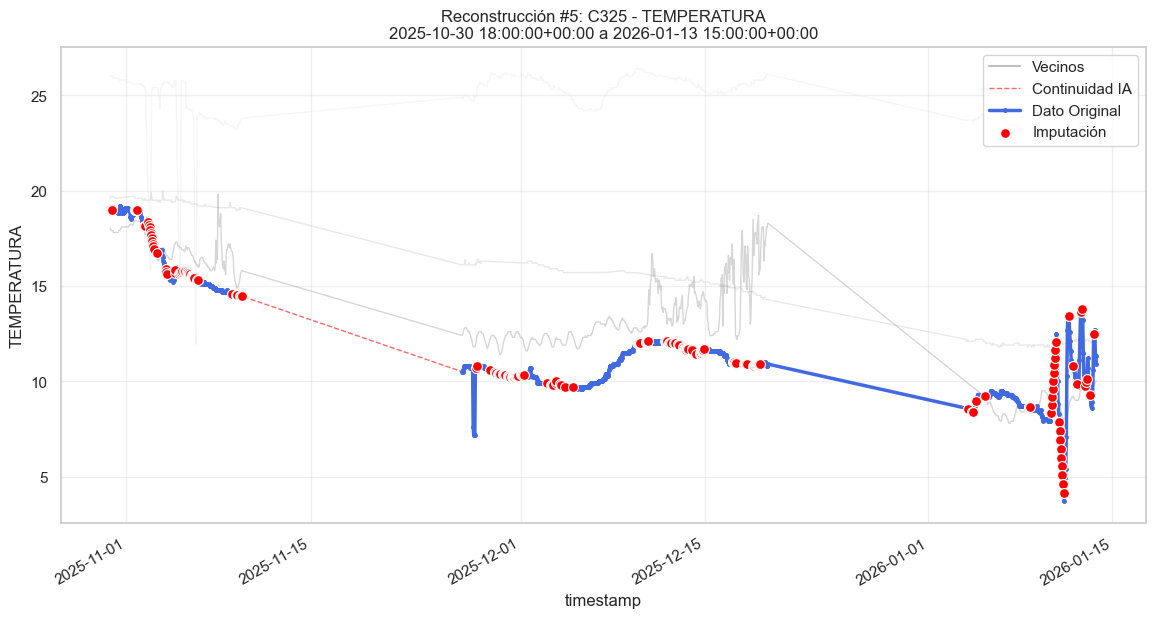

In [1363]:
print("\nInspeccionando un caso VIP (Imputación Multivariante):")
df_audit_mice, mask_mice = auditoria_blindada(df_clean, df_final)

# Filtramos la máscara para ver solo casos que estaban en la lista VIP
# (Para asegurarnos de ver la magia del MICE y no una interpolación lineal)
if mask_mice.sum() > 0:
    for i in range(1, 6):
        visualizar_ranking_imputacion(df_audit_mice, mask_mice, df_topology_clean, posicion=i)

In [1364]:
def informe_final_huecos(df_inicial, df_final):
    print("--- INFORME FINAL DE COBERTURA DE DATOS ---")

    # 1. Conteo Total
    total_ini = df_inicial['value'].isna().sum()
    total_fin = df_final['value'].isna().sum()
    recuperados_total = total_ini - total_fin
    pct_recup_total = (recuperados_total / total_ini) * 100 if total_ini > 0 else 0

    print(f"HUECOS TOTALES INICIALES: {total_ini}")
    print(f"HUECOS TOTALES FINALES:   {total_fin}")
    print(f"DATOS RECUPERADOS:        {recuperados_total} ({pct_recup_total:.2f}%)")
    print("-" * 60)

    # 2. Desglose por Métrica
    # Agrupamos por métrica para ver los NaNs
    grp_ini = df_inicial.groupby('metric')['value'].apply(lambda x: x.isna().sum())
    grp_fin = df_final.groupby('metric')['value'].apply(lambda x: x.isna().sum())

    # Creamos un DataFrame resumen
    resumen = pd.DataFrame({'Inicial': grp_ini, 'Final': grp_fin})
    resumen['Recuperados'] = resumen['Inicial'] - resumen['Final']
    resumen['% Recuperado'] = (resumen['Recuperados'] / resumen['Inicial']) * 100
    resumen['% Recuperado'] = resumen['% Recuperado'].fillna(0)  # Por si dividimos por cero

    # Ordenamos por porcentaje de éxito
    resumen = resumen.sort_values('% Recuperado', ascending=False)

    print("\nDESGLOSE POR MÉTRICA:")
    print(resumen.to_markdown(floatfmt=".1f"))

    return resumen


# Ejecutar informe
df_resumen = informe_final_huecos(df_clean, df_final)

--- INFORME FINAL DE COBERTURA DE DATOS ---
HUECOS TOTALES INICIALES: 102069
HUECOS TOTALES FINALES:   94516
DATOS RECUPERADOS:        7553 (7.40%)
------------------------------------------------------------

DESGLOSE POR MÉTRICA:
| metric           |   Inicial |   Final |   Recuperados |   % Recuperado |
|:-----------------|----------:|--------:|--------------:|---------------:|
| CLOROFILA        |    2163.0 |  1517.0 |         646.0 |           29.9 |
| TEMPERATURA      |    6071.0 |  4725.0 |        1346.0 |           22.2 |
| OXIGENO DISUELTO |    5002.0 |  4181.0 |         821.0 |           16.4 |
| PH               |   15520.0 | 13470.0 |        2050.0 |           13.2 |
| TURBIDEZ         |    7163.0 |  6407.0 |         756.0 |           10.6 |
| AMONIO           |    7647.0 |  6958.0 |         689.0 |            9.0 |
| CARBONO ORGANICO |    2006.0 |  1837.0 |         169.0 |            8.4 |
| FICOCIANINAS     |    4251.0 |  3924.0 |         327.0 |            7.7 |
| NIVEL 

In [1365]:
def analizar_duracion_huecos(df, metrica):
    """
    Cuenta cuánto duran los huecos consecutivos.
    FIX: Usa las columnas explícitas en el groupby para evitar KeyErrors en Series.
    """
    # Filtramos y ordenamos (vital para que shift funcione)
    df_m = df[df['metric'] == metrica].sort_values(['sensor_id', 'timestamp'])

    if df_m.empty:
        print(f"La métrica {metrica} no tiene datos.")
        return

    # Detectar si es NaN
    is_nan = df_m['value'].isna()

    # Identificar bloques: cada vez que cambia de True a False (o viceversa) incrementa el id del bloque
    # Esto agrupa rachas consecutivas de datos y rachas consecutivas de huecos
    bloques = (is_nan != is_nan.shift()).cumsum()

    # Al agrupar, usamos explícitamente df_m['sensor_id']
    # Calculamos la duración de TODOS los bloques (sean datos o huecos)
    # count() cuenta filas, si son datos horarios = horas.
    todas_duraciones = df_m.groupby([df_m['sensor_id'], bloques])['timestamp'].count()

    # Ahora necesitamos saber qué bloques eran de Huecos (is_nan == True)
    # Agrupamos la serie is_nan usando las mismas claves
    es_bloque_hueco = is_nan.groupby([df_m['sensor_id'], bloques]).first()

    # Filtramos: Solo nos quedamos con las duraciones donde el bloque era de huecos
    duraciones_huecos = todas_duraciones[es_bloque_hueco]

    # --- RESULTADOS ---
    print(f"--- ANÁLISIS DE FALLOS: {metrica} ---")
    print(f"   Total de interrupciones detectadas: {len(duraciones_huecos)}")
    print(duraciones_huecos.describe())

    plt.figure(figsize=(12, 5))
    # Usamos escala logarítmica porque suele haber muchos huecos de 1h y pocos de 1000h
    plt.hist(duraciones_huecos, bins=50, color='salmon', edgecolor='black', log=True)
    plt.title(f"Histograma de Duración de Huecos: {metrica}\n(Eje Y Logarítmico)")
    plt.xlabel("Duración del apagón (Horas)")
    plt.ylabel("Frecuencia (Log)")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

Analicemos los huecos presentes para validar que el modelo no se ha vuelto loco imputando todo

--- ANÁLISIS DE FALLOS: AMONIO ---
   Total de interrupciones detectadas: 108
count    108.000000
mean      64.425926
std       72.230835
min        1.000000
25%       16.000000
50%       32.500000
75%       98.250000
max      238.000000
Name: timestamp, dtype: float64


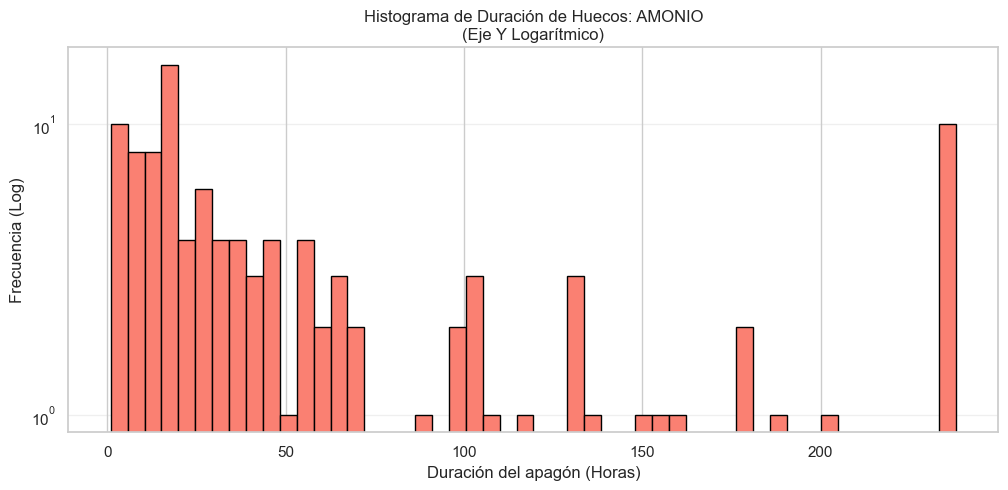

--- ANÁLISIS DE FALLOS: CONDUCTIVIDAD ---
   Total de interrupciones detectadas: 29
count      29.000000
mean     1281.275862
std         0.454859
min      1281.000000
25%      1281.000000
50%      1281.000000
75%      1282.000000
max      1282.000000
Name: timestamp, dtype: float64


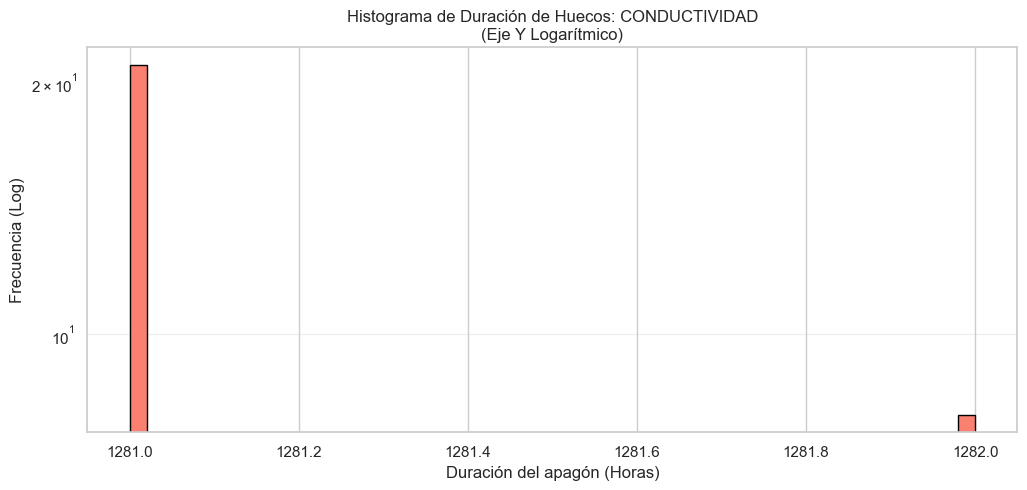

--- ANÁLISIS DE FALLOS: NITRATOS ---
   Total de interrupciones detectadas: 36
count     36.000000
mean     171.722222
std       76.889015
min       17.000000
25%      102.000000
50%      235.000000
75%      236.000000
max      238.000000
Name: timestamp, dtype: float64


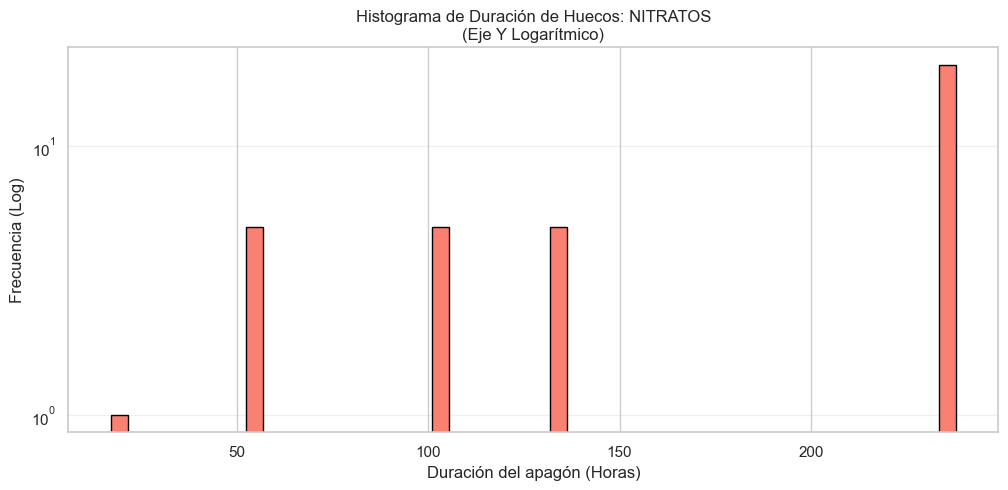

--- ANÁLISIS DE FALLOS: OXIGENO DISUELTO ---
   Total de interrupciones detectadas: 33
count      33.000000
mean      126.696970
std       307.038931
min         2.000000
25%         7.000000
50%        17.000000
75%        72.000000
max      1282.000000
Name: timestamp, dtype: float64


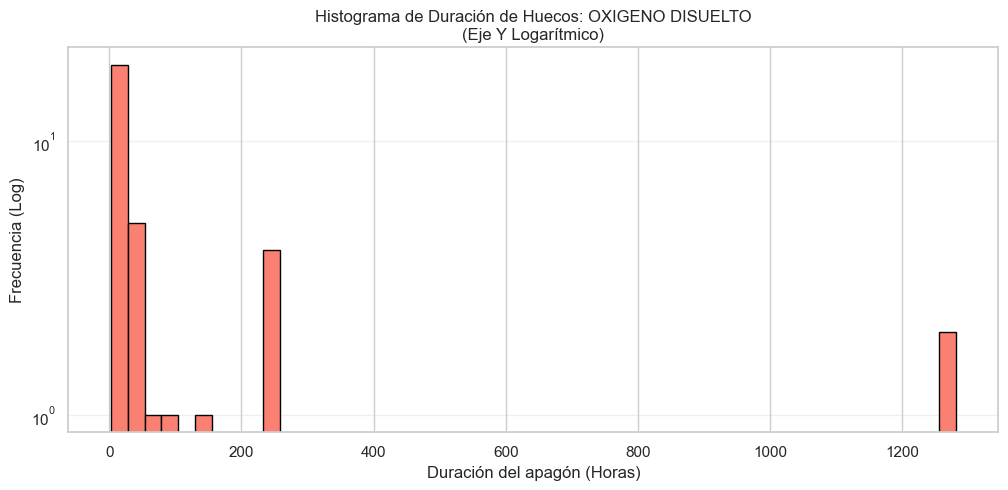

--- ANÁLISIS DE FALLOS: PH ---
   Total de interrupciones detectadas: 232
count     232.000000
mean       58.060345
std       147.315122
min         2.000000
25%        18.000000
50%        26.000000
75%        45.500000
max      1282.000000
Name: timestamp, dtype: float64


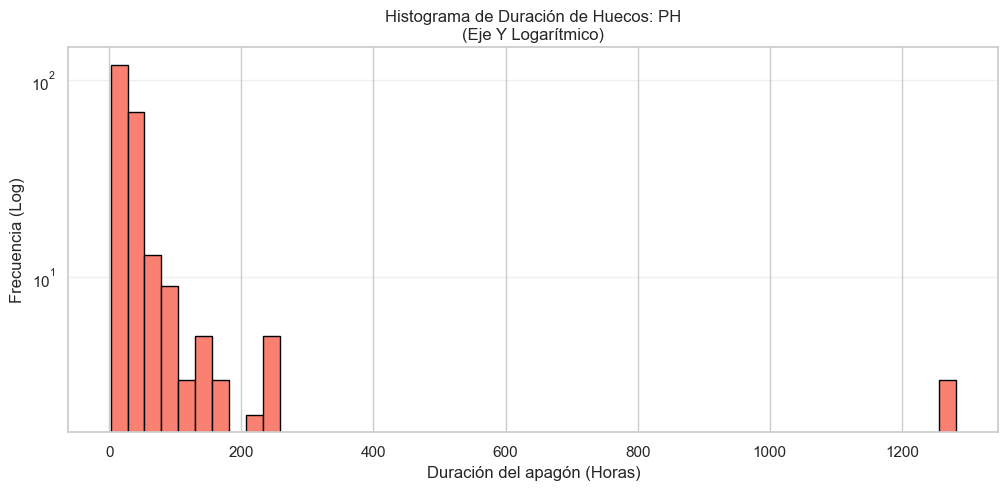

--- ANÁLISIS DE FALLOS: TEMPERATURA ---
   Total de interrupciones detectadas: 63
count      63.000000
mean       75.000000
std       226.900788
min         1.000000
25%        11.000000
50%        17.000000
75%        27.500000
max      1282.000000
Name: timestamp, dtype: float64


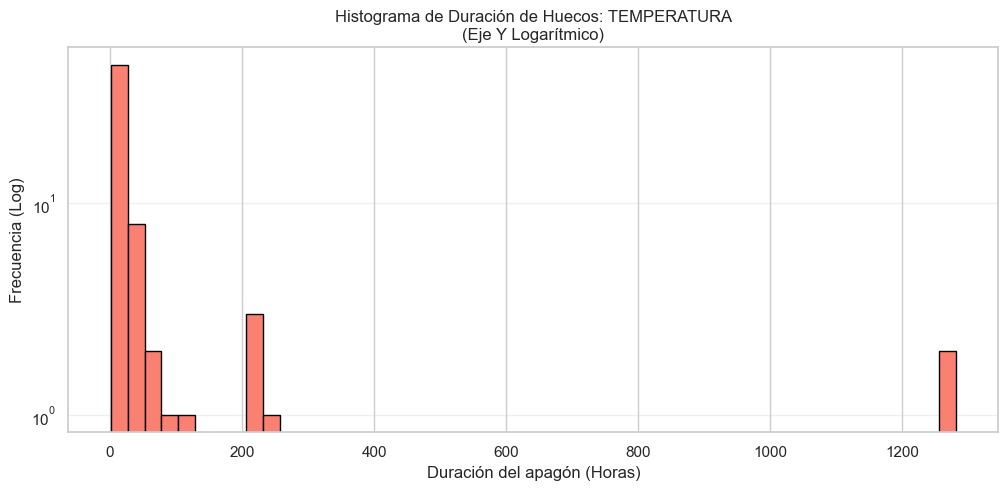

--- ANÁLISIS DE FALLOS: TURBIDEZ ---
   Total de interrupciones detectadas: 116
count    116.000000
mean      55.232759
std       72.202175
min        1.000000
25%        9.000000
50%       25.000000
75%       57.000000
max      238.000000
Name: timestamp, dtype: float64


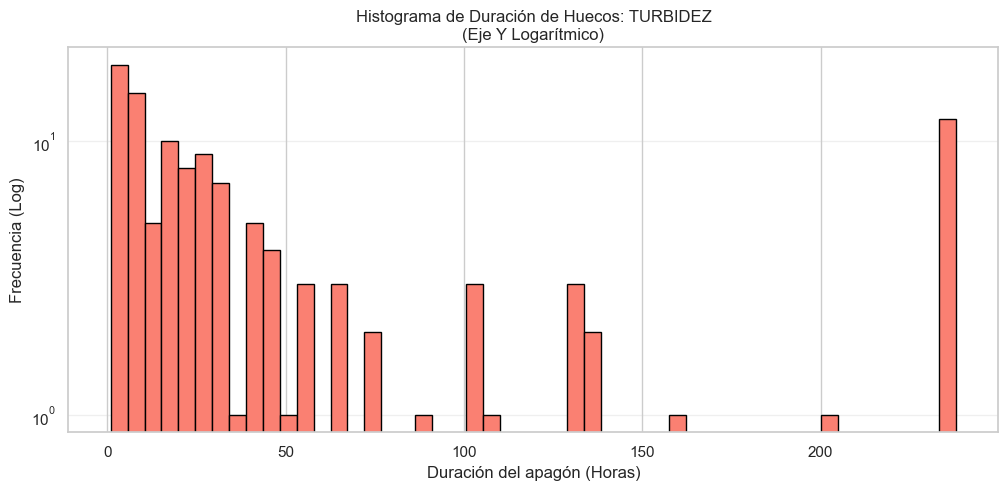

--- ANÁLISIS DE FALLOS: CLOROFILA ---
   Total de interrupciones detectadas: 26
count      26.000000
mean       58.346154
std       249.999671
min         1.000000
25%         2.250000
50%         4.500000
75%        11.000000
max      1282.000000
Name: timestamp, dtype: float64


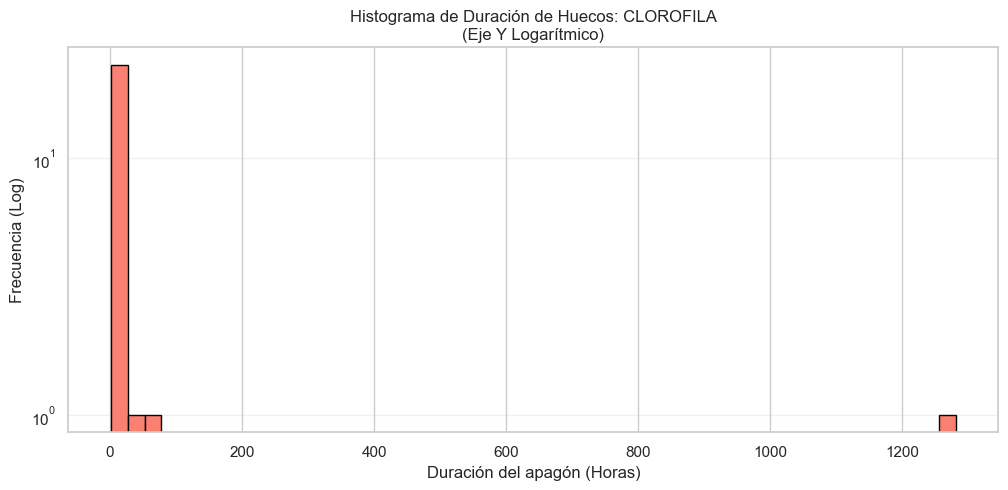

--- ANÁLISIS DE FALLOS: FICOCIANINAS ---
   Total de interrupciones detectadas: 51
count     51.000000
mean      76.941176
std       84.463818
min        1.000000
25%        9.500000
50%       41.000000
75%      115.000000
max      237.000000
Name: timestamp, dtype: float64


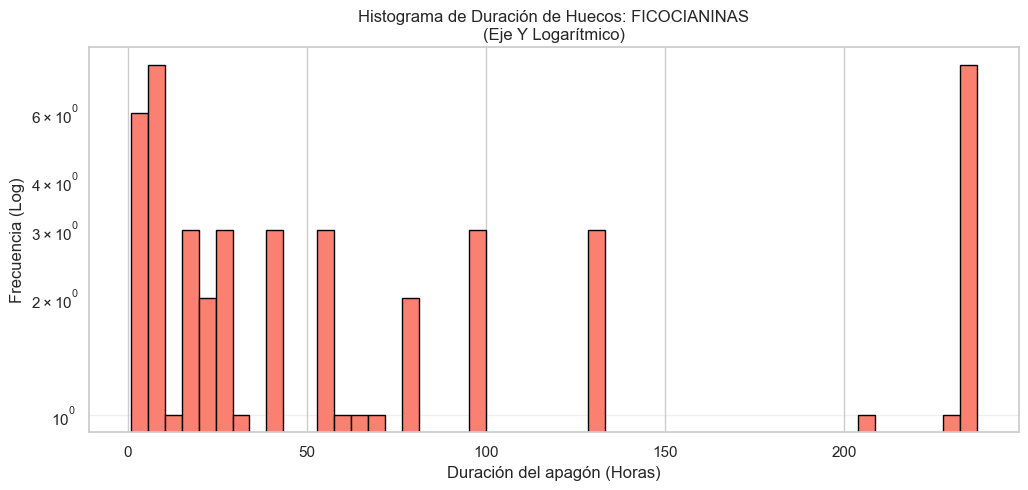

--- ANÁLISIS DE FALLOS: CARBONO ORGANICO ---
   Total de interrupciones detectadas: 32
count     32.000000
mean      57.406250
std       75.809974
min        4.000000
25%        8.750000
50%       21.500000
75%       60.500000
max      238.000000
Name: timestamp, dtype: float64


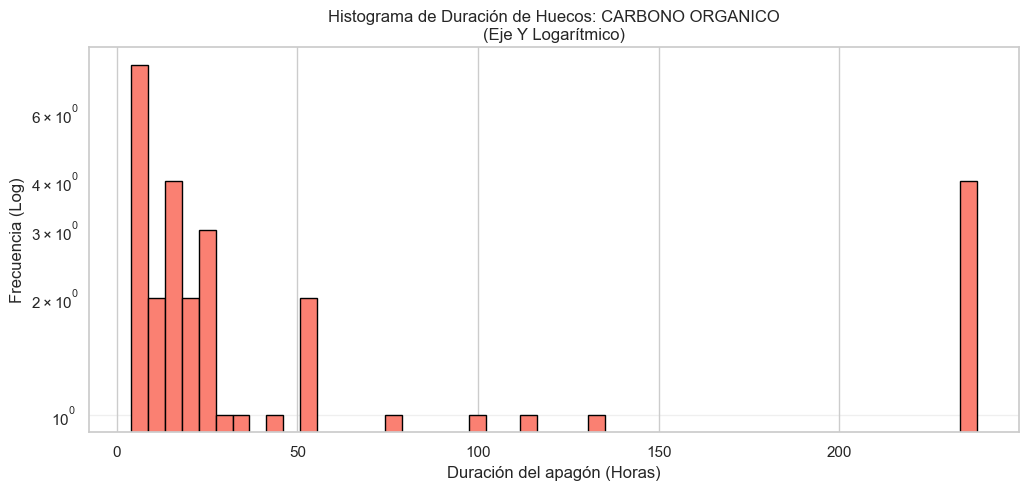

--- ANÁLISIS DE FALLOS: FOSFATOS ---
   Total de interrupciones detectadas: 28
count     28.000000
mean      77.321429
std       76.308367
min        8.000000
25%       27.000000
50%       43.500000
75%      105.500000
max      238.000000
Name: timestamp, dtype: float64


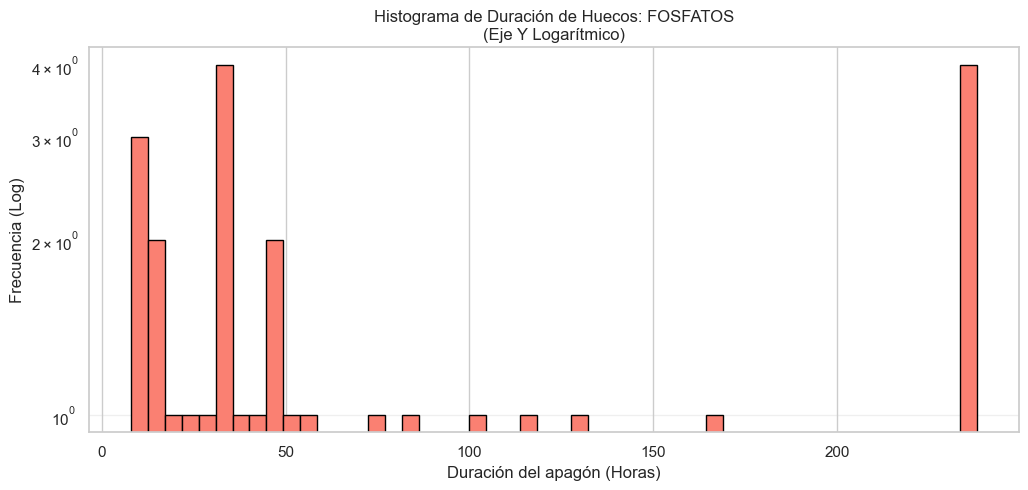

--- ANÁLISIS DE FALLOS: NIVEL ---
   Total de interrupciones detectadas: 41
count     41.000000
mean     146.170732
std       83.252598
min       10.000000
25%       94.000000
50%      124.000000
75%      227.000000
max      234.000000
Name: timestamp, dtype: float64


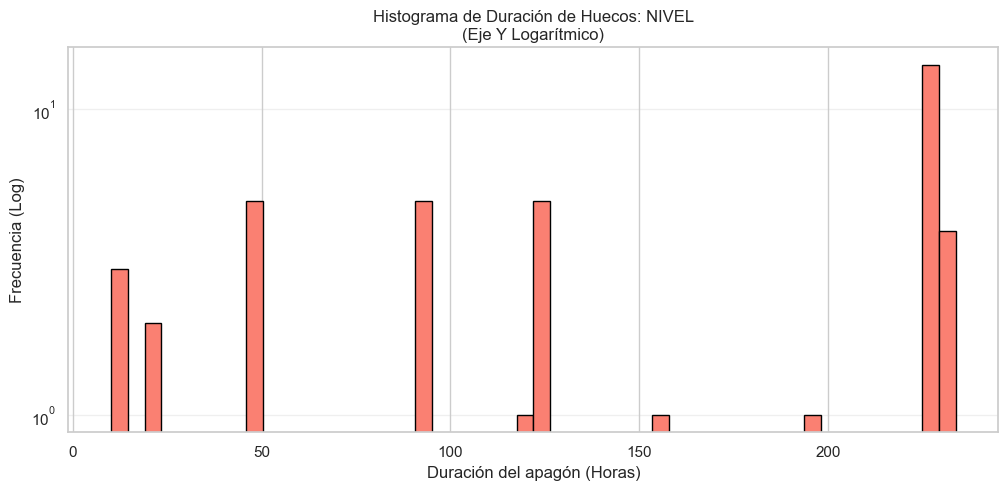

In [1366]:
for m in df['metric'].unique():
    analizar_duracion_huecos(df_final, m)

Vemos que hay huecos de 1h. Estos son residuos de interpolaciones. Vamos a investigar y a cerrarlas

In [1367]:
def investigar_residuos(df, metrica, horas_gap=1):
    print(f"--- INVESTIGANDO RESIDUOS DE {horas_gap}H EN {metrica} ---")

    # 1. Filtramos y Ordenamos (Vital)
    df_m = df[df['metric'] == metrica].sort_values(['sensor_id', 'timestamp'])

    if df_m.empty:
        print("Métrica no encontrada.")
        return

    # 2. Lógica de bloques
    is_nan = df_m['value'].isna()
    bloques = (is_nan != is_nan.shift()).cumsum()

    # 3. Agrupamos usando la columna EXPLÍCITA para evitar KeyError
    #    (df_m['sensor_id'] en lugar de 'sensor_id')

    # Cuenta tamaño de cada bloque
    counts = df_m.groupby([df_m['sensor_id'], bloques])['timestamp'].count()

    # Mira si el bloque es de NaNs o de Datos
    # Al agrupar una Serie (is_nan), debemos pasar la columna externa df_m['sensor_id']
    es_hueco = is_nan.groupby([df_m['sensor_id'], bloques]).first()

    # 4. Filtramos
    # Buscamos bloques que sean Huecos (True) Y que duren exactamente 'horas_gap'
    candidatos = counts[(counts == horas_gap) & es_hueco]

    if candidatos.empty:
        print("No hay residuos de ese tamaño exacto.")
        return

    print(f"Se encontraron {len(candidatos)} casos de residuos de {horas_gap}h.")

    # 5. Visualizar el primer caso ("La escena del crimen")
    sensor_culpable, bloque_id = candidatos.index[0]

    # Truco para sacar las filas de ese bloque específico
    mask_bloque = (df_m['sensor_id'] == sensor_culpable) & (bloques == bloque_id)
    indices_hueco = df_m[mask_bloque].index

    # Mostramos contexto (3 antes, el hueco, 3 después)
    idx_central = indices_hueco[0]

    try:
        posicion = df_m.index.get_loc(idx_central)
        inicio = max(0, posicion - 3)
        fin = min(len(df_m), posicion + 4)  # +4 para ver 3 después (el slice es exclusivo)

        rango_visual = df_m.iloc[inicio: fin]

        print(f"\nCASO DETECTADO: Sensor {sensor_culpable}")
        print(rango_visual[['timestamp', 'value']])
        print("\nINTERPRETACIÓN:")
        print("   Si ves valores numéricos justo antes del NaN, es que Pandas rellenó")
        print("   hasta su límite (limit=2) y se detuvo justo ahí, dejando este residuo.")

    except KeyError:
        print("Error visualizando el índice (puede que el índice no sea único).")


In [1368]:
for m in df['metric'].unique():
    investigar_residuos(df_final, m, horas_gap=1)

--- INVESTIGANDO RESIDUOS DE 1H EN AMONIO ---
Se encontraron 7 casos de residuos de 1h.

CASO DETECTADO: Sensor C306
                     timestamp     value
3840 2026-01-13 16:00:00+00:00  3.135929
3841 2026-01-13 17:00:00+00:00  3.135929
3842 2026-01-13 18:00:00+00:00  3.135929
3843 2026-01-13 19:00:00+00:00       NaN
3844 2025-10-02 15:00:00+00:00  0.182322
3845 2025-10-02 16:00:00+00:00  0.262364
3846 2025-10-02 17:00:00+00:00  0.182322

INTERPRETACIÓN:
   Si ves valores numéricos justo antes del NaN, es que Pandas rellenó
   hasta su límite (limit=2) y se detuvo justo ahí, dejando este residuo.
--- INVESTIGANDO RESIDUOS DE 1H EN CONDUCTIVIDAD ---
No hay residuos de ese tamaño exacto.
--- INVESTIGANDO RESIDUOS DE 1H EN NITRATOS ---
No hay residuos de ese tamaño exacto.
--- INVESTIGANDO RESIDUOS DE 1H EN OXIGENO DISUELTO ---
No hay residuos de ese tamaño exacto.
--- INVESTIGANDO RESIDUOS DE 1H EN PH ---
No hay residuos de ese tamaño exacto.
--- INVESTIGANDO RESIDUOS DE 1H EN TEMPERA

Vamos a proceder a cerrar esos porquitos huecos de una hora.

In [1369]:
def cerrar_huecos_residuales(df):
    """
    Sella huecos de 1 hora que hayan quedado tras la interpolación principal.
    Es una operación quirúrgica y segura.
    """
    print("--- SELLANDO HUECOS RESIDUALES (1H) ---")
    df_final = df.copy()

    # 1. Identificar huecos de 1h
    # Pivotamos por métrica para asegurar que no mezclamos sensores
    partes = []
    for metric in df_final['metric'].unique():
        df_m = df_final[df_final['metric'] == metric].copy()

        pivot = df_m.pivot(index='timestamp', columns='sensor_id', values='value')

        # Interpolamos con un límite de 1 solo para cerrar esos residuos
        # 'linear' es suficiente y seguro para 1 hora
        pivot_closed = pivot.interpolate(method='linear', limit=1, limit_direction='both')

        # Reconstruir formato largo
        df_filled = pivot_closed.stack(future_stack=True).reset_index().rename(columns={0: 'value'})
        df_filled['metric'] = metric

        # Recuperar metadatos
        cols_meta = [c for c in df_m.columns if c not in ['timestamp', 'sensor_id', 'metric', 'value']]
        if cols_meta:
            meta_ref = df_m[['timestamp', 'sensor_id'] + cols_meta].drop_duplicates()
            df_filled = pd.merge(df_filled, meta_ref, on=['timestamp', 'sensor_id'], how='left')

        partes.append(df_filled)

    df_res = pd.concat(partes, ignore_index=True)

    nans_antes = df['value'].isna().sum()
    nans_despues = df_res['value'].isna().sum()
    print(f"   Se han sellado {nans_antes - nans_despues} residuos de 1h.")

    return df_res

In [1370]:
df_final = cerrar_huecos_residuales(df_final)

--- SELLANDO HUECOS RESIDUALES (1H) ---
   Se han sellado 1432 residuos de 1h.


Finalmente eliminamos los nulos que no hemos podido imputar y exportamos

In [1373]:
df_final

,timestamp,sensor_id,value,metric,batch_x,block_change_x,block_id_x,delta_abs_x,epsilon_x,hour_x,...,max_score_in_block_y,own_time_diff_y,prev_timestamp_y,prev_value_y,segment_id_y,severity_rate_y,stagnation_score_y,trans_value_y,unit_y,z_score_abs_y
0,2025-10-02 14:00:00+00:00,C302,0.392042,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-02 14:00:00+00:00,C304,2.128232,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-10-02 14:00:00+00:00,C306,3.061520,AMONIO,batch1,True,5423.0,NaN,0.000352,14.0,...,NaN,NaT,NaT,NaN,25.0,185.486006,NaN,3.06152,mg/l,1.255137
3,2025-10-02 14:00:00+00:00,C307,0.182322,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-10-02 14:00:00+00:00,C308,0.000000,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278177,2026-01-13 19:00:00+00:00,C323,0.460000,NIVEL,batch10,False,26261.0,0.00,0.010000,19.0,...,2.0,0 days 01:00:00,2026-01-13 18:00:00+00:00,0.46,138.0,1.000000,2.0,0.46000,m,2.175787
278178,2026-01-13 19:00:00+00:00,C327,NaN,NIVEL,batch10,False,31635.0,0.00,0.010000,19.0,...,240.0,0 days 01:00:00,2026-01-13 18:00:00+00:00,0.00,162.0,1.000000,240.0,0.00000,m,0.000000
278179,2026-01-13 19:00:00+00:00,C328,NaN,NIVEL,batch10,False,33163.0,0.00,0.010000,19.0,...,240.0,0 days 01:00:00,2026-01-13 18:00:00+00:00,0.00,170.0,1.000000,240.0,0.00000,m,0.000000
278180,2026-01-13 19:00:00+00:00,C329,0.990000,NIVEL,batch10,False,34889.0,0.00,0.010000,19.0,...,6.0,0 days 01:00:00,2026-01-13 18:00:00+00:00,0.99,178.0,1.000000,6.0,0.99000,m,0.384391


In [1376]:
df_export = df_final.dropna(subset=['value'])

Exportamos el archivo para los compañeros

In [1378]:
# df_export.to_csv("/home/duo/Projects/proyecto-computacion-I/data/datasets/Métricas_inputadas_.csv")

Conclusiones del Análisis

El proceso de depuración y tratamiento de datos realizado en este notebook ha permitido transformar el dataset original en un conjunto de datos limpio, continuo y apto para análisis posteriores o modelado. A continuación se resumen los hitos principales del flujo de trabajo:

1. Detección y Gestión de Flatlines: Se identificaron y trataron eficazmente los periodos de "flatlines" (señales planas o valores constantes anómalos). Estos segmentos, que a menudo indican fallos en sensores o errores de registro, fueron convertidos a valores nulos (NaN) para evitar sesgos estadísticos en el análisis. Se utilizó una estrategia para no definir una ventana fija, sino que los estancamientos son detectados por acumular puntos de sospecha.

2. Imputación Avanzada de Datos: Tras la limpieza de las anomalías, se aplicaron técnicas de imputación avanzada para reconstruir la continuidad de la serie. Esto asegura que la estructura temporal y las relaciones entre variables se preserven, superando las limitaciones de métodos simples como la eliminación de filas o el llenado con ceros.

3. Generación del Dataset Final: El proceso culminó con la creación de un conjunto de datos consolidado, df_final. Como paso de control de calidad final, se eliminaron los registros remanentes que no pudieron ser imputados satisfactoriamente (específicamente en la columna value), asegurando la integridad del entregable. Previa a esta generación final, se iteró varias veces sobre algunos hiperparametros para afinar más las imputaciones.

4. Exportación de Resultados: Los datos procesados se han exportado en el objeto df_export, el cual representa la versión definitiva y depurada del dataset, lista para su integración en etapas productivas o de machine learning.

Duo Xu 16 enero 2025

In [1380]:
df_export.head()

,timestamp,sensor_id,value,metric,batch_x,block_change_x,block_id_x,delta_abs_x,epsilon_x,hour_x,...,max_score_in_block_y,own_time_diff_y,prev_timestamp_y,prev_value_y,segment_id_y,severity_rate_y,stagnation_score_y,trans_value_y,unit_y,z_score_abs_y
0,2025-10-02 14:00:00+00:00,C302,0.392042,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-02 14:00:00+00:00,C304,2.128232,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-10-02 14:00:00+00:00,C306,3.061520,AMONIO,batch1,True,5423.0,NaN,0.000352,14.0,...,NaN,NaT,NaT,NaN,25.0,185.486006,NaN,3.06152,mg/l,1.255137
3,2025-10-02 14:00:00+00:00,C307,0.182322,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-10-02 14:00:00+00:00,C308,0.000000,AMONIO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Verificar que no hay picazos de temperatura

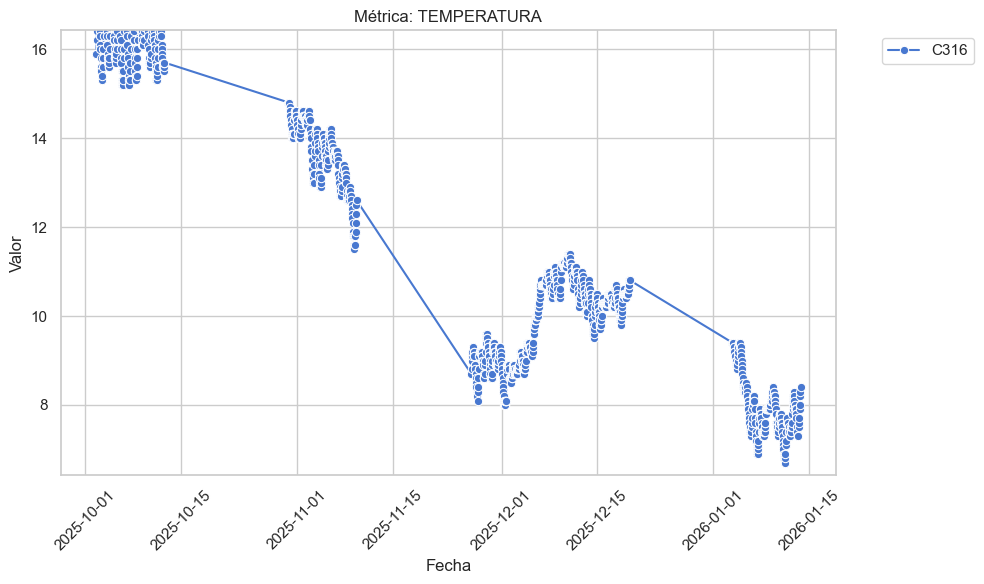

In [1403]:
pintar_graficas(df_export[(df_export['metric']=='TEMPERATURA') & (df_export['sensor_id']=='C316')])

Éxito